## <center>Combination and Astrometric Calibration of NIRSPAO Slit-viewing Camera Images</center>
### <center>An AO Image of the IR Continuum in the Center of NGC 253</center>
------

In this notebook, I align and combine SCAM images at different slit positions into a slit-free mosaic, and then perform astrometric calibration of this combined image. The result is a $0.1''=1~\mathrm{pc}$-resolution image of the $4\mu\mathrm{m}$ continuum in the central starburst region, near the radio source TH2 and the nuclear bar ([Cohen et al. 2020](https://doi.org/10.1093/mnras/staa292)). Through the process, I also derive the __sky coordinates of all slit positions__, which lets us measure velocity structure from the spectra.

Required packages:
 ```imexam``` to infer FWHM of the PSF in the SCAM images
 ```photutils``` for source detection
 ```stsci``` for mosaicing, coordinate matching, astrometric registration

Source detection and image combination:

1. Detect bright IR point sources in SCAM images and derive precise image (pixel) coordinates
2. Match xy-xy coordinates between SCAM images with overlapping sources
3. Compute shifts for image alignment into a mosaic, and XY positions of slits in mosaic
4. Combine images into mosaic (use image scaling, smoothing when necessary)

Astrometric calibration/registration using catalogs:

5. Perform source detection on SCAM mosaic sources
6. Match XY coordinates of SCAM mosaic with reference catalog: Hubble Source Catalog v3 or GAIA DR3
7. Fit the WCS of the SCAM mosaic using matched coordinates
8. Transform XY coordinates of slits to RA,DEC

Notes:
- The slit PA is given by the image header DCS keyword ```ROTDEST```, held constant at $\phi=45^\circ$ 
- Rather than matching to available reference catalogs, can run source detection on a high-resolution IR image with accurate astrometry, such as recent Hubble WFC3 imaging 
---

### Imports

In [20]:
#%matplotlib notebook
import matplotlib, pylab, os, astropy
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams['figure.autolayout']=True
# matplotlib.rcParams['figure.figsize']=[8.0,6.0]
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

from astropy.io import fits,ascii
from astropy.table import Table,QTable
from astropy.io import ascii
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import mad_std,sigma_clipped_stats,SigmaClip
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch, MinMaxInterval, ZScaleInterval
from regions import read_ds9

from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from photutils import CircularAperture
from photutils import DAOStarFinder,Background2D,MedianBackground

from regions import PixCoord,RectanglePixelRegion,write_ds9
# from drizzlepac import tweakreg
# from stsci.stimage import xyxymatch

#from tweakwcs.matchutils import MatchCatalogs,TPMatch
# from tweakwcs.linearfit import iter_linear_fit


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Define sorted filelist of images, and slit mask image

In [2]:
imagefiles = glob("nscam_median_spec00??.fits")
 # remove sky frmaes, bad frames from image list and sort
[imagefiles.remove("nscam_median_spec%s.fits"%frame) for frame in  ("0057","0062")]#,"0065","0069","0070","0071",'0072','0073','0074')]
imagefiles=np.sort(imagefiles)
slitmaskfile = "slit_0.41x2.26_scam_mask.fits"
slitregfile="slit_0.41x2.26_scam.reg"
# catalog = "/Users/dcohen/RESEARCH/NGC253/HLADATA-12011918935/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_sexphot_trm.cat"
# #catalog = "/Users/dcohen/RESEARCH/NGC253/HLADATA-12011918935/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_daophot_trm.cat"
# calimage = "/Users/dcohen/RESEARCH/NGC253/HST/MAST_2019-10-23T2023/HLA/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_total_drz.fits"

### Make the slit mask

In [155]:
from regions import PixCoord,RectanglePixelRegion,write_ds9


#xslit,yslit=(121.8,95.0) # same coordinates for all SCAM images
xslit,yslit=(120.0,95.0) # same coordinates for all SCAM images
slitwidth=np.ceil(2.1 * (0.0407/0.0149)) # slit width in pixels, grow width by factor to cover full slit
slitlength=np.ceil(1.05 * (2.26/0.0149)) # slit length in pixels, grow length by factor ~1.1
ndim=(256,256)
# define slit region
slitreg = RectanglePixelRegion(PixCoord(x=xslit,y=yslit),height=slitwidth,width=slitlength,angle=u.deg*(90.0-14.27))
#smask=slitreg.to_mask()
write_ds9([slitreg],slitregfile,coordsys='image')
slitmask=slitreg.to_mask().to_image(ndim).astype(np.bool)
# save region and mask
#slitreg.writeto("slit_0.41x2.26_scam.reg")
fits.writeto(slitmaskfile,data=slitmask.astype(int), overwrite=True)

### Define functions for source detection



In [25]:
# source finder using DAOFind, which assumes a uniform background
def find_sources(data,mask=None,fwhm=10.0,thresh=1.5,bkgboxsize=64): 
    
    if bkgboxsize==0:
        mean,bg,bgrms = sigma_clipped_stats(data, mask=mask, sigma=3.0, \
                                          cenfunc=np.nanmedian, stdfunc=np.nanstd, maxiters=10)
    else:
        bkg=Background2D(data,box_size=bkgboxsize,mask=mask,sigma_clip=SigmaClip(sigma=3.0,maxiters=3,cenfunc=np.nanmedian,stdfunc=np.nanstd))
        bkg.background #*= ~mask #.astype(int) # make background within masked region have value = 0
        bkg.background_rms #*= ~mask #.astype(int)
        bg=bkg.background_median
        bgrms=bkg.background_rms_median
    
#     bkg.background *= ~mask#.astype(int) # make background within masked region have value = 0
#     bkg.background_rms *= ~mask#.astype(int)
    
#     threshold = detect_threshold(data, nsigma=thresh, background=bkg.background,mask=mask)
#     print(threshold.mean())
    
    # calculate sigma-clipped stats to get std 
    #mean,median,std = sigma_clipped_stats(bkg.background, mask=mask, sigma=3.0, \
    #                                      cenfunc=np.nanmedian, stdfunc=np.nanstd, maxiters=10) 

    # create background image
 #   bkg_estimator = MedianBackground()
    
#     bkg = Background2D(data, box_size=bkgboxsize, mask=mask, exclude_percentile=10.0, sigma_clip=SigmaClip(sigma=3.0),\
#                        filter_size=int(fwhm),edge_method='extend')#, filter_size=int(fwhm))
#     bkg2D=bkg.background
#     bkgrms=bkg.background_rms_median
    
   # datasub=np.ma.masked_array(data-bkg2D, mask=mask)
   # datasub=np.ma.masked_array(data-median, mask=mask)
    
    #threshold = detect_threshold(data, snr=10.0)[0, 0]

    daofind = DAOStarFinder(fwhm=fwhm, threshold=bgrms*thresh, roundlo=-1.0, roundhi=1.0, \
                            sharplo=0.05, sharphi=1.0, exclude_border=False)  
    
    sources = daofind(data-bg, mask=mask)
    
    if sources==None:
        return (-1,bg,bgrms)
    else:
        return sources,bg,bgrms

# source finder using segmentation mapping, allowing for 2D background
def find_sources_seg(data, mask=None, fwhm=10.0, thresh=2.0, bkgboxsize=64):
    
    bkg = Background2D(data,box_size=bkgboxsize,mask=mask,sigma_clip=SigmaClip(sigma=3.0))
    
    bkg.background *= ~mask#.astype(int) # make background within masked region have value = 0
    bkg.background_rms *= ~mask#.astype(int)

    threshold = bkg.background + thresh * bkg.background_rms
    
    kernel_sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # what kernel fwhm to filter with
    kernel = Gaussian2DKernel(kernel_sigma,x_size=3*fwhm,y_size=3*fwhm)
    kernel.normalize()

    segm = detect_sources(data, threshold, mask=mask, npixels=4, filter_kernel=kernel, connectivity=8)
    
    if segm==None:
        print("error: segmentation produced no source detections. returning.")
        return (-1,bkg.background,bkg.background_rms)
    else: # proceed with deblending
        segm_db = deblend_sources(data, segm, npixels=4 ,filter_kernel=kernel, \
                                    nlevels=64, contrast=0.0001, connectivity=8)
    
        cat = source_properties(data-bkg.background, segm_db, background=bkg.background, mask=mask)#segm_deblend)
    
        sources=cat.to_table()
    
        return sources,bkg.background,bkg.background_rms



### Detect sources in SCAM images and save coords, display



4 6 20
Image:  nscam_median_spec0053.fits
Trimmed image shape:  (244, 244)
1
Image:  nscam_median_spec0054.fits
Trimmed image shape:  (244, 244)
2
Image:  nscam_median_spec0055.fits
Trimmed image shape:  (244, 244)
3
Image:  nscam_median_spec0056.fits
Trimmed image shape:  (244, 244)
4
Image:  nscam_median_spec0058.fits
Trimmed image shape:  (244, 244)
5
Image:  nscam_median_spec0059.fits
Trimmed image shape:  (244, 244)
6
Image:  nscam_median_spec0060.fits
Trimmed image shape:  (244, 244)
7
Image:  nscam_median_spec0061.fits
Trimmed image shape:  (244, 244)
8
Image:  nscam_median_spec0063.fits
Trimmed image shape:  (244, 244)
9
Image:  nscam_median_spec0064.fits
Trimmed image shape:  (244, 244)
10
Image:  nscam_median_spec0065.fits
Trimmed image shape:  (244, 244)
11
Image:  nscam_median_spec0066.fits
Trimmed image shape:  (244, 244)
12
Image:  nscam_median_spec0067.fits
Trimmed image shape:  (244, 244)
13
Image:  nscam_median_spec0068.fits
Trimmed image shape:  (244, 244)
14
Image:  

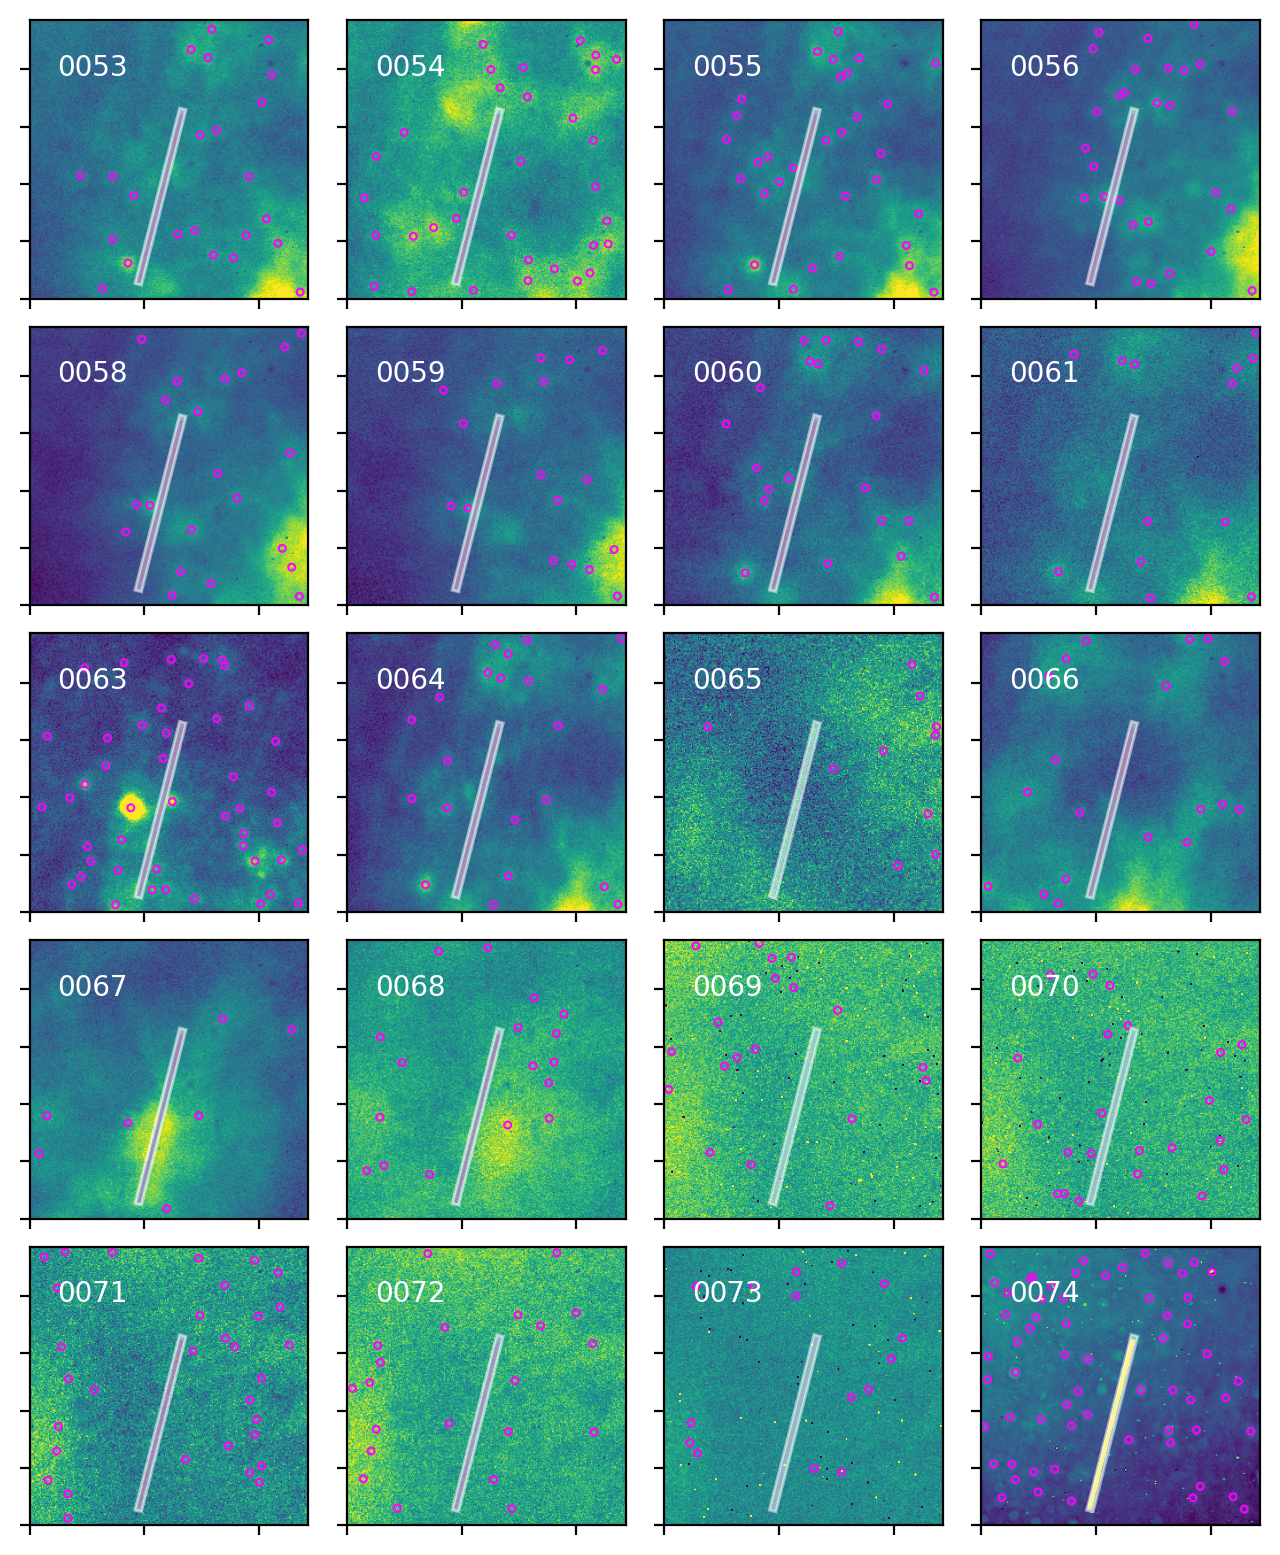

In [176]:
# define "good" subset of images
npix_trim=6
# print(np.arange(256)[npix_trim],np.arange(256)[256-npix_trim])
# print(np.arange(256)[npix_trim:256-npix_trim])
detect_func=find_sources

# ~~ Read in the slit mask (1s inside of slit, 0s elsewhere)
slitmaskfile = "slit_0.41x2.26_scam_mask.fits"
slitregfile="slit_0.41x2.26_scam.reg"
slitmask=fits.getdata(slitmaskfile).astype(np.bool)
slitreg=read_ds9(slitregfile)[0]

# Get x,y position of slit in trimmed images set by trim_range
slitregtrimmed=slitreg.copy()
slitregtrimmed.center=PixCoord(x=slitreg.center.x-npix_trim,y=slitreg.center.y-npix_trim)
slitmasktrimmed=slitmask[npix_trim:-npix_trim,npix_trim:-npix_trim]
write_ds9([slitregtrimmed],"slit_trim.reg",coordsys='image')
fits.writeto( "slit_mask_trim.fits",data=slitmasktrimmed.astype(int), overwrite=True)

# ~~ Define figure properties
Nimage = len(imagefiles)

ncol=4
nrow=Nimage//ncol +1 * ( Nimage%2 == 0) ##+ 2*int( ncol%2 > 0)
print(ncol,nrow,Nimage)

# ~~ Instantiate list of source catalogs (astropy Tables)
#imagecats=[]

# ~~ Loop through images and run source detection
fig=plt.figure(1,(ncol*2,nrow*2))
for i in range(Nimage):
    
    print("Image: ",imagefiles[i])
    
    # read image and slit, make masked array
    hdu=fits.open(imagefiles[i])[0]
    data=hdu.data
    hdr=hdu.header
    data[np.isnan(data)]=0.
  #  slitreg=pyregion.open(slitregfile).as_imagecoord(hdr)
    imagedatama=np.ma.masked_array(data,mask=slitmask)
    hdumasked=fits.PrimaryHDU(data=imagedatama.data,header=hdu.header)
    
    # trim left,top,bottom edges of image (bad columns)
    imagetrimmed=imagedatama[npix_trim:-npix_trim,npix_trim:-npix_trim]
    print("Trimmed image shape: ",imagetrimmed.shape)
    
    #tab,rms,bg=find_sources(imagetrimmed.data,mask=imagetrimmed.mask,\
    #                        fwhm=12.0,thresh=2.0,bkgboxsize=imagetrimmed.shape)
    tab,bg,rms=detect_func(imagetrimmed.data,mask=imagetrimmed.mask,fwhm=16.0,thresh=3.0,\
                            bkgboxsize=imagetrimmed.shape[0]//2) 
  #  print(tab['sharpness'],tab['sky'],tab['peak'],tab['roundness1'],tab['roundness2'])
    # save trimmed, background subtracted image
    fits.writeto( "nscam_s%s_trim.fits"%imagefiles[i][-9:-5],\
                 data=imagetrimmed.data*(1-imagetrimmed.mask)-bg,overwrite=True)
    
    zscale=ZScaleInterval()
    zmin,zmax=zscale.get_limits(imagetrimmed.data)
    norm=ImageNormalize(imagetrimmed.data,stretch=SqrtStretch())
    print(i+1)
    ax=fig.add_subplot(nrow,ncol,i+1)
    ax.imshow(imagetrimmed.data,origin='lower',cmap='viridis',vmin=zmin, vmax=zmax)
    slitregtrimmed.plot(color='white',linewidth=1.0, fill=True,alpha=0.5)
    ax.annotate(imagefiles[i][-9:-5],xy=(0.1,0.8),xycoords="axes fraction",\
                color='white',size=10)
    
    ax.set_xlim(0,imagetrimmed.shape[1]-1)
    ax.set_ylim(0,imagetrimmed.shape[0]-1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    if tab==-1:
        continue
    else:
      #  print(tab.info)
        # transpose to (x,y)
      #  print(tab.info)
        xy=np.transpose((tab['xcentroid'], tab['ycentroid']))
       # Cxy=np.array((tab['covar_sigx2'],tab['covar_sigxy'],tab['covar_sigy2'])).T # covariance
      #  print(Cxy)
       # xysigma=np.sqrt( Cxy.sum(axis=1) )  #( Cxy, axis=1)**(-0.5)
       # print(xysigma)
        #print(xysigma,xysigma.shape)
        np.savetxt( "nscam_s%s_trim.coo"%imagefiles[i][-9:-5],xy+1.0,fmt=['%.4f','%.4f'],header='X Y')
#         coordtab=Table({'xcentroid':xy[:,0],\
#                     'ycentroid':xy[:,1]})#,\
#                   #  'centroid_sigma':xysigma,
#                  #   'bkg_median':tab['background_mean'],\
#                   #  'bkg_value':tab['background_at_centroid'] })
    
#         ascii.write(coordtab, "nscam_s%s_trim.coo"%imagefiles[i][-9:-5],formats={'xcentroid':'%.4f',\
#                                                                           'ycentroid':'%.4f'})#,\
                                                                        #  'centroid_sigma':'%.4f',\
                                                                        #  'bkg_median':'%.2e',\
                                                                        #  'bkg_value':'%.2e'})

        
        #~~~ Plot sources with size proportional to coord uncertainty, and format subplot
        patches = [CircularAperture(xy[m,:], r=3) for m in range(xy.shape[0])]
        [p.plot(color='magenta', lw=0.8, alpha=0.95) for p in patches]
        
plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.tight_layout()
plt.show()
    

### Estimate coordinates of 1-2 reference objects spanning all images. Use PyRAF `imexam` (open DS9 in new window prior to running).

In [96]:
from pyraf import iraf
# use pyraf to measure coordinates of ref object

images=sorted(glob('nscam*trim.fits'))[:-6]
print(images)

imexam=iraf.images.tv.imexam
rimexam=iraf.images.tv.rimexam
rimexam.radius=10

['nscam_s0053_trim.fits', 'nscam_s0054_trim.fits', 'nscam_s0055_trim.fits', 'nscam_s0056_trim.fits', 'nscam_s0058_trim.fits', 'nscam_s0059_trim.fits', 'nscam_s0060_trim.fits', 'nscam_s0061_trim.fits', 'nscam_s0063_trim.fits', 'nscam_s0064_trim.fits', 'nscam_s0065_trim.fits', 'nscam_s0066_trim.fits', 'nscam_s0067_trim.fits', 'nscam_s0068_trim.fits']


Run again using object in frame 63 -- should then have shifts spanning all 

In [147]:
imexam(','.join(images),logfile="imexam.coo.2")

z1=-130. z2=175.9252
z1=-119. z2=107.
z1=-107. z2=191.4978
z1=-98. z2=229.
z1=-106. z2=231.
z1=-98. z2=229.
z1=-107. z2=191.4978
z1=-119. z2=107.
Origin: 96.17 170.00
Log file imexam.coo.2 open
  96.17  170.00     74. 96.1670  170.00    0.00    0.00    0.00   0.0
z1=-107. z2=191.4978
 135.33  220.83    97.5 96.1670  170.00   39.17   50.83   64.17  52.4
z1=-98. z2=229.
z1=-106. z2=231.
z1=-93. z2=184.5
z1=-83. z2=177.3504
 128.67  220.00    -37. 96.1670  170.00   32.50   50.00   59.63  57.0
z1=-89.5 z2=169.5
 128.67  220.83     58. 96.1670  170.00   32.50   50.83   60.33  57.4
z1=-51.5 z2=159.3347
  76.17    9.17    106. 96.1670  170.00  -20.00 -160.83  162.07 262.9
z1=-78. z2=214.4486
 125.33  214.17     74. 96.1670  170.00   29.17   44.17   52.93  56.6
z1=-46.5 z2=54.
z1=-98. z2=174.6888
  62.83  210.00     21. 96.1670  170.00  -33.33   40.00   52.07 129.8
z1=-109. z2=161.
z1=-108.7269 z2=90.5
z1=-130. z2=175.9252
 142.83  222.50     66. 96.1670  170.00   46.67   52.50   70.24  48.4
z

### Calculate shifts between images for alignment. Use PyRAF `imalign`.

#### Generate input files for `imalign` from the `imexam` log files. Used two objects.

In [117]:
log='imexam.log.1'
ixref=1|
#inplist='pre-align/'
fo=open(log,'r')
lines=fo.readlines()
imlist=[] # to be list of images with measurement of object position
xy=[] # to be object position in each image in imlist
shifts=[]
for j in range(len(lines)-1):
    if (lines[j][0]=='#') & (lines[j+1][0]!='#'): # line starting with 'Origin', definining origin of shifts
        i=lines[j].split()[2]
        imlist.append(i)
        xy.append(np.array(lines[j+1].split()[0:2],dtype=float))
        shifts.append(-1.0*np.array(lines[j+1].split()[5:7],dtype=float))
fo.close()
imlist=np.array(imlist)
#dxy=xy[0]-xy
ref=imlist[ixref]

# REDEFINE REFERENCE AS FRAME 55
shifts=np.array(shifts)
shiftref=np.resize(shifts[ixref,:],shifts.shape)
shifts-=shiftref
#print(shifts-[shifts[1,:]]))#, shifts[:][1]-shifts[1][1])
#print(shift0)
np.savetxt('images.1',imlist,'%s')
np.savetxt('estshifts.1',shifts,['%.1f','%.1f'])

In [ ]:
# REDEFINE REFERENCE AS FRAME 55

### Run PyRAF `imcentroid` on list of input images `images.1`, with initial guesses on shifts `shifts.1` to calculate precise shifts

In [309]:
#import reproject
from pyraf import iraf
from reproject.mosaicking import reproject_and_coadd

inimages='images.1' # list of filenames of trimmed images
inshifts='estshifts.1' # rough estimates of shifts from imexam
outimages='aligned.1' # suffix for output images pre-ceding the .fits
outshifts='imcentroid.out.1' # output results from imcentroid giving precise image shifts
slitfile="slit_trim.reg" # ds9 region file for slit in trimmed images
refimage="nscam_s0055_trim.fits" # reference image file
refcoord="nscam_s0055_trim.coo" # reference image source coordinates (X,Y)

# Read image lists, etc
inlist=np.loadtxt(inimages,dtype=str)
outlist=[i[:-4]+outimages+".fits" for i in inlist]
nimage=inlist.size

# define input and output image sizes
ixref=np.where(inlist==refimage)[0]
estshifts=np.loadtxt("estshifts.1")
estshifts-=estshifts[ixref,:]
np.savetxt('estshifts.1',estshifts,['%.1f','%.1f'])
#estshiftminmax=(np.min(estshifts,0),np.max(estshifts,0))
insize=fits.getdata(refimage).shape
#outsize=(int(insize[0]*3),int(insize[1]*3))

# Define x,y pixel coord bounds of reference image in output image, which is centered
#xrref=(outsize[1]//2-insize[1]//2,outsize[1]//2+insize[1]//2)
#yrref=(outsize[0]//2-insize[0]//2,outsize[0]//2+insize[0]//2)
#print("Output image size: ",outsize[0],outsize[1])#xrref,yrref)


#~~ CALCULATE SHIFTS using imcentroid
iraf.images.immatch.imcentroid('@'+inimages,reference=refimage,coords=refcoord,\
              shifts='estshifts.1',boxsize=7,bigbox=19,niterate=50,tolerance=0.01,\
                verbose='no',Stdout=outshifts)


# function to read precise shifts from imcentroid output file
def read_shifts(file):
    
    fo=open(file,'r')
    #print(fo.readlines()[1:])
    out=[]
    for row in fo.readlines()[1:-2]:
        if row.split()[0]=='#':
            continue
        else:
            out.append((row.split()[0],row.split()[1],row.split()[3]))
    fo.close()
    
    return np.array(out)



#~~ READ SHIFTS FROM IMCENTROID
shiftarr=read_shifts(outshifts)
xyshifts=shiftarr[:,1:].astype(float) # 
intshifts=xyshifts.astype(int) # integral portion of shifts
fracshifts=np.sign(xyshifts) * (np.abs(xyshifts) - np.abs(intshifts)) # fractional portion of shifts

print(xyshifts.min(axis=0),xyshifts.max(axis=0))
print(xyshifts,intshifts,fracshifts)

#loshift=np.ceil(np.max(-1.*xyshifts[:,0])) , np.ceil(np.max(-1.*xyshifts[:,1])) )
maxshift=np.ceil(np.max(np.abs(xyshifts),0) ).astype(int)
print(maxshift)

# compute size of output image based off of the min/max shifts
outsize=(insize[0]+2*maxshift.max(),\
        insize[1]+2*maxshift.max() ) #2*int(np.max(np.abs(xyshifts[:,0]))))
# if maxdim<=insize[0]:
#     maxdim=insize[0]
#print(maxdim)
#outdim=maxdim+(1-int(maxdim%2==0)) # round to nearest even integer
print("OUTPUT DIM ",outsize)
#outsize=(outdim,outdim)

# Define x,y pixel coord bounds of reference image in output image, which is centered
xrref=(outsize[1]//2-insize[1]//2, outsize[1]//2+insize[1]//2)
yrref=( outsize[0]//2-insize[0]//2, outsize[0]//2+insize[0]//2)
print("Input, Output image size: ",insize[0],outsize[0])#xrref,yrref)

# read original slit region, center
slitorig=read_ds9(slitfile)[0]
xslitref=xrref[0]+slitorig.center.x
yslitref=yrref[0]+slitorig.center.y

#iraf.images.imgeom.imshift(outlist[ii],outlist[ii],xshift=fracshifts[ii,0],yshift=fracshifts[ii,1],\
#                      interp_type='poly3',boundary_type='constant',constant=0.) 

# wcsiref=set_init_wcs(fits.PrimaryHDU(data=np.zeros(outsize)),\
#                      crpix=(xslitref,yslitref),\
#                      crval=(11.8885885,-25.2876669),pixscale=0.0149,rot=360.-45.0)
# wcsiref.printwcs()
imstack=[]
maskstack=[]
#reprojin=[]
slitxy=[]
slitregions=[]
# #ncol=3
# #nrow=nimage//ncol + 1 #* ( nimage%2 == 0) ) ##+ 2*int( ncol%2 > 0)
# #fig=plt.figure(1,(ncol*2,nrow*2))
for ii in range(nimage): # Loop through images

    # Clean previously generated image
    iraf.images.imutil.imdelete(outlist[ii])
    
    # Create blank image with same size as output size
    iraf.images.imutil.imexpr("repl(0,%i)"%(outsize[0]),outlist[ii],dim="%i,%i"%(outsize[1],outsize[0]))
  
    # Use integer shifts to calculate lower and upper bounds of input image within the output image
    xri=(xrref[0]+intshifts[ii,0],xrref[1]+intshifts[ii,0])
    yri=(yrref[0]+intshifts[ii,1],yrref[1]+intshifts[ii,1])
    # Copy input image into output frame
    iraf.images.imutil.imcopy(inlist[ii],\
           "%s[%i:%i,%i:%i]"%(outlist[ii],xri[0],xri[1],yri[0],yri[1]))
    # Perform fractional shifts to complete alignment
    iraf.images.imgeom.imshift(outlist[ii],outlist[ii],xshift=fracshifts[ii,0],yshift=fracshifts[ii,1],\
                      interp_type='spline3',boundary_type='nearest') 

    
    # Read input slit region, calculate slit pixel coords in output frame and add to list of slit centers
    #slitorig=read_ds9("slit_trim.reg")[0]
    slitcenter=PixCoord(x=xslitref+xyshifts[ii,0], y=yslitref+xyshifts[ii,1]  )
    slitxy.append((float(slitcenter.x),float(slitcenter.y)))
    slitreg=RectanglePixelRegion(slitcenter,\
                    height=slitorig.height,width=slitorig.width,angle=slitorig.angle)
    write_ds9([slitreg],"slit_%s.align.1.reg"%(outlist[ii][6:11]),coordsys='image')
    
    # also add to list of all regions
    slitregions.append(slitreg)

    # Read in aligned image data, and define mask where pixel value = 0
    datalign=fits.open(outlist[ii])[0].data
    slitmask=slitreg.to_mask().to_image(outsize).astype(np.bool)
    xx,yy=np.meshgrid(np.arange(datalign.shape[1]),np.arange(datalign.shape[0]))
   # print(xx[:5,:5])
    maskalign= slitmask | ~( (xx>xri[0]-1) & (xx<xri[1]-1) & (yy>yri[0]-1) & (yy<yri[1]-1) ) # mask both the slit, and any pixels outside the border of the input image
    # define masked array
    #datmasked=np.ma.masked_array(datalign.astype(np.float),mask=maskalign.astype(np.bool))
    imstack.append(datalign.astype(np.float))
    maskstack.append(maskalign)

#    # zscale=ZScaleInterval()
#     zmin,zmax=zscale.get_limits(datmasked)
#     norm=ImageNormalize(datmasked,stretch=SqrtStretch())
#   #  print(i+1)
#     ax=fig.add_subplot(nrow,ncol,ii+1)
#     ax.imshow(datmasked.data,origin='lower',cmap='viridis',norm=norm)
#     #slitalign.plot(color='white',linewidth=1.0, fill=True,alpha=0.5)
#    # ax.annotate(inlist[ii],xy=(0.1,0.8),xycoords="axes fraction",\
#    #             color='white',size=5)
    
#     ax.set_xlim(0,datmasked.shape[1]-1)
#     ax.set_ylim(0,datmasked.shape[0]-1)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.set_xlabel("")
#     ax.set_ylabel("")
outlist=np.array(outlist,dtype=str)
slitxy=np.array(slitxy,dtype=np.float)

# Define masked cube with aligned image data and masks. Save as FITS cube.
imagecube=np.ma.masked_array(np.array(imstack),mask=np.array(maskstack))
fits.writeto("imagestack.1.fits",data=imagecube.data,overwrite=True)
fits.writeto("maskstack.1.fits",data=imagecube.mask.astype(int),overwrite=True)
# save aligned slit coords/region
# print(np.array(outlist).shape,np.array(slitxy).shape)
# print(np.array([slitxy,(outlist)]))
print(slitxy)
np.vstack((slitxy[:,0],slitxy[:,1],outlist)).T
np.savetxt("slits.align.1.xy",np.vstack((slitxy[:,0],slitxy[:,1],outlist)).T,fmt='%s',header='X_SLIT Y_SLIT IMAGE')
write_ds9(slitregions,"slits_all.align.1.reg",coordsys='image')     

[-37.087 -67.462] [105.021 212.3  ]
[[ 40.108  50.149]
 [  0.      0.   ]
 [ 58.816 212.3  ]
 [ 11.165   6.987]
 [ 74.068  10.876]
 [ -6.51   -0.854]
 [-37.087 -58.04 ]
 [-31.112 -56.326]
 [-34.556 -54.318]
 [  3.831   3.451]
 [  7.187   4.992]
 [105.021 -67.462]
 [ 90.91  -61.252]] [[ 40  50]
 [  0   0]
 [ 58 212]
 [ 11   6]
 [ 74  10]
 [ -6   0]
 [-37 -58]
 [-31 -56]
 [-34 -54]
 [  3   3]
 [  7   4]
 [105 -67]
 [ 90 -61]] [[ 0.108  0.149]
 [ 0.     0.   ]
 [ 0.816  0.3  ]
 [ 0.165  0.987]
 [ 0.068  0.876]
 [-0.51  -0.854]
 [-0.087 -0.04 ]
 [-0.112 -0.326]
 [-0.556 -0.318]
 [ 0.831  0.451]
 [ 0.187  0.992]
 [ 0.021 -0.462]
 [ 0.91  -0.252]]
[106 213]
OUTPUT DIM  (670, 670)
Input, Output image size:  244 670
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% - done
nscam_s0054_trim.fits -> nscam_s0054_trim.aligned.1.fits[253:497,263:507]
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% - done
nscam_s0055_trim.fits -> nscam_s0055_trim.aligned.1.fits[213:457,213:457]
10% 20% 30% 40% 50% 60% 70% 80% 90% 10

# COMBINE IMAGES INTO MOSAIC

In [310]:
from astropy.convolution import convolve, convolve_fft, interpolate_replace_nans
fwhm_conv=0.1/0.0149
fwhm_bg=20.0
imcube=fits.getdata("imagestack.1.fits")
maskcube=fits.getdata('maskstack.1.fits')
imstack=np.ma.masked_array(imcube,mask=maskcube)
#medimage=np.ma.median(imstack,axis=0)
#fits.writeto("nscam_median_stack.fits",data=medimage.data,overwrite=True)
imscaledcube=[]
for ii in range(imstack.shape[0]):
#     bg=np.ma.median(imstack[ii])
#     imsub=imstack[ii]-bg
    #kern=Gaussian2DKernel()
    #imconv=convolve()
    bg_kernel_sigma = fwhm_bg / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # what kernel fwhm to filter with
    bg_kernel = Gaussian2DKernel(bg_kernel_sigma)
    bg_kernel.normalize()
    
    #imconv=convolve(imsub,kernel)
   # imii=imstack[ii].data.copy()
    #imii[np.where(imstack[ii].mask.astype(bool)==True)]
  #  background=MedianBackground()
#     bg=Background2D(imstack[ii].data,(64,64),mask=imstack[ii].mask,sigma_clip=SigmaClip(sigma=3.0,\
#                                             cenfunc=np.ma.median, stdfunc=np.ma.std, maxiters=3))
#     bkg=background.calc_background(imstack[ii])
#     print(bkg)

    mean,median,std = sigma_clipped_stats(imstack[ii],mask=imstack[ii].mask, sigma=3.0,\
                                           cenfunc=np.ma.median, stdfunc=np.ma.std, maxiters=2)
    
    print("Bg mean,median,rms: ",mean,median,std)
   # bgimg=bg.background_median *np.ones(imstack[ii].shape) #* #median
   # rmsimg=bg.background_rms_median *np.ones(imstack[ii].shape) #*bg.background_rms
   # bgimg[np.where(imstack[ii].mask==True)]=0.
   # rmsimg[np.where(imstack[ii].mask==True)]=0.
    imscaled=(imstack[ii]-median)/std**2
    imscaledcube.append(imscaled)

imscaledstack=np.ma.masked_array(imscaledcube,mask=maskcube)

# imavg=np.ma.mean(imstackproc,axis=0)
meanimage=np.ma.mean(imscaledstack,axis=0)
medimage=np.ma.median(imscaledstack,axis=0)
stdimage=np.ma.std(imscaledstack,axis=0)
medsmooth=convolve( medimage, kernel, boundary=None,\
                   nan_treatment='fill',fill_value=0., mask=medimage.data==0.)

kernel_sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # what kernel fwhm to filter with
kernel = Gaussian2DKernel(kernel_sigma)
kernel.normalize()

fits.writeto("nscam_mosaic_med.fits",data=medimage.data,overwrite=True)
fits.writeto("nscam_mosaic_med.sm.fits",data=medsmooth,overwrite=True)
fits.writeto("nscam_mosaic_mean.fits",data=meanimage.data,overwrite=True)
#fits.writeto("nscam_sigma_stack.fits",data=stdimage.data,overwrite=True)
# # kernel_sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # what kernel fwhm to filter with
# # kernel = Gaussian2DKernel(kernel_sigma)
# # kernel.normalize()
# # imout = convolve(imavg, kernel)
# # #print(medstack.shape)
# # wcsiref=set_init_wcs(fits.PrimaryHDU(data=np.zeros(outsize)),\
# #                       crpix=(xrefpix,yrefpix),\
# #                       crval=(11.8885931,-25.2876711),pixscale=0.0149,rot=360.-45.0)
# hdustack=fits.PrimaryHDU(data=imavg.data,header=wcsiref.to_header())
# hdustack.writeto("nscam_median_stack.fits",overwrite=True)

Bg mean,median,rms:  4.68088164000277 2.0 24.750061414508355
Bg mean,median,rms:  5.105616616491797 2.0 29.551819898320844
Bg mean,median,rms:  4.979046814799177 0.0 24.6686591208804
Bg mean,median,rms:  0.7591512029297868 -1.0 35.44975373322566
Bg mean,median,rms:  4.279598521606614 2.0 27.362556661565247
Bg mean,median,rms:  4.198975143675605 1.0 25.6298720530961
Bg mean,median,rms:  11.594941704035875 7.0 36.952493795845875
Bg mean,median,rms:  12.452931558047185 11.0 40.089445918988915
Bg mean,median,rms:  4.169415641397589 4.0 27.966311293801347
Bg mean,median,rms:  6.34529203539823 4.0 27.046432279951592
Bg mean,median,rms:  5.089837426982898 2.0 27.252234259193973
Bg mean,median,rms:  4.335767846696566 1.0 30.77126423952467
Bg mean,median,rms:  1.0267467153919778 0.0 18.420715270343322


# CALIBRATE WCS OF MOSAIC AND DERIVE RA/DEC OF SLITS

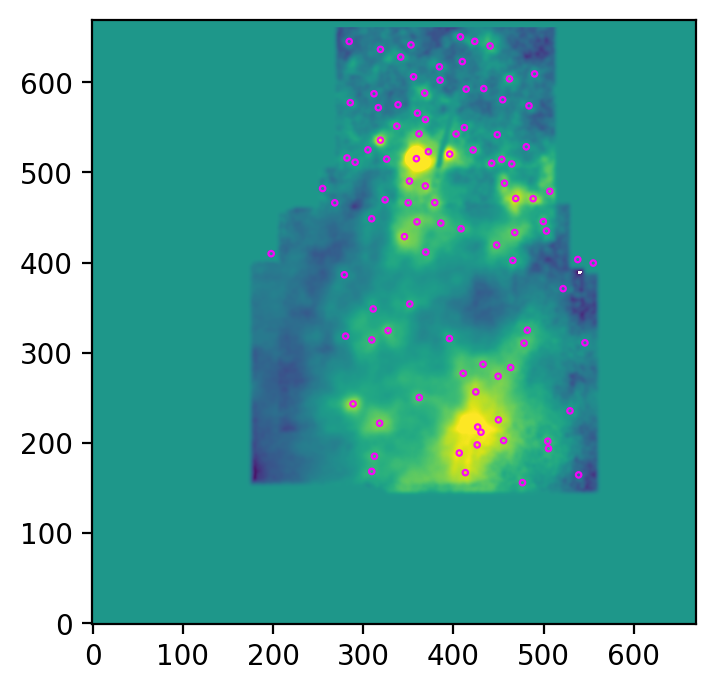

In [27]:
# Detect sources in mosaic
#mosimage="nscam_mosaic_med.fits"
coodir="n253/scam/coords/"
mosdir="n253/scam/mosaic/"
mosimage="nscam_mosaic_med.sm.fits"
hdumos=fits.open(mosdir+mosimage)
datmos=hdumos[0].data
hdrmos=hdumos[0].header

maskmos=(datmos==0.)

# DETECT OBJECTS
#obj,bg,rms=find_sources(datmos,mask=maskmos,fwhm=20.0,thresh=3.0,\
#                            bkgboxsize=(60,60))
obj,bg,rms=find_sources(datmos,mask=maskmos,fwhm=16.0,thresh=4.0,bkgboxsize=48)

xyobj=np.transpose((obj['xcentroid'],obj['ycentroid']))
labels=np.arange(xyobj.shape[0])+1
np.savetxt(coodir+mosimage[:-5]+'.coo',np.vstack([xyobj[:,0]+1.0,xyobj[:,1]+1.0,\
                labels]).T,fmt=['%.4f','%.4f','%i'],header='X    Y    ID')
zscale=ZScaleInterval(nsamples=5000,contrast=0.1)
minmax=MinMaxInterval()
#help(ZScaleInterval)
vmin,vmax=minmax.get_limits(np.ma.masked_array(datmos,mask=maskmos))
zmin,zmax=zscale.get_limits(np.ma.masked_array(datmos,mask=maskmos))
norm=ImageNormalize(np.ma.masked_array(datmos,mask=maskmos),stretch=SqrtStretch(),vmin=zmin,vmax=zmax)

plt.figure()
ax=plt.subplot(111)
ax.imshow(datmos,origin='lower',cmap='viridis',norm=norm)
#slitregtrimmed.plot(color='white',linewidth=1.0, fill=True,alpha=0.5)

patches = [CircularAperture(xyobj[m,:], r=3) for m in range(xyobj.shape[0])]
[p.plot(color='magenta', lw=0.8, alpha=0.95) for p in patches]
#[ax.annotate(labels[n],xy=xyobj[n,:]+3.0,xycoords="data",\
#                color='magenta',size=5,weight='bold') for n in range(xyobj.shape[0])]
        
plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.tight_layout()
plt.show()
# ax.set_xlim(0,imagetrimmed.shape[1]-1)
# ax.set_ylim(0,imagetrimmed.shape[0]-1)
# ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.set_xlabel("")
#     ax.set_ylabel("")

#### Take HST (or other reference catalog), cut it down to only sources within r<8'' of approximate center of FoV, save RA/DEC to current directory

#### __SKIP__ if catalog already created

In [285]:
cat="/Users/dcohen/RESEARCH/NGC253/HST/HLA_HSCv3_catalogs/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_daophot_trm.cat"
#cat="/Users/dcohen/RESEARCH/NGC253/HST/HLA_HSCv3_catalogs/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_sexphot_trm.cat"
refcat='hst_12206_wfc3_dao.cat' # output reference catalog w RA/DEC of nearby sources
scsearch=SkyCoord(11.888660400,-25.287603400,frame='icrs',unit=(u.deg,u.deg)) # define search coord for ref catalog

# s0055 as ref frame
#xref,yref=(339.1240,497.5873) # s0064 as ref frame

# Load HST catalog and cut out all sources at R>8''
num_cat,x_cat,y_cat,ra_cat,dec_cat=np.loadtxt(cat,unpack=True,usecols=(0,1,2,3,4))
#print(ra_cat,dec_cat)
sccat=SkyCoord(ra_cat,dec_cat,frame='icrs',unit=(u.degree,u.degree))
sepcat=scsearch.separation(sccat) # calculate separation
ixnear=np.where(sepcat.arcsec <= 10.)

print("Num HST sources within 10'' of SCAM reference point: ",np.size(ixnear))
sccatnear=sccat[ixnear]
numnear=num_cat[ixnear]
# Save nearby sources to a new catalog
print(numnear.shape,sccatnear.ra.degree.shape)
np.savetxt(refcat,np.vstack([sccatnear.ra.degree,\
         sccatnear.dec.degree,numnear]).T, fmt=['%-13.8f','%-13.7f','%i'], \
           header='RA DEC ID')

Num HST sources within 10'' of SCAM reference point:  373
(373,) (373,)


### Use ccxymatch to generate a list of matched image, sky coordinates (X,Y,RA,DEC)

In [28]:
imcoords=iraf.images.imcoords
coodir="n253/scam/coords/"
mosdir="n253/scam/mosaic/"

mosimage="nscam_mosaic_med.sm.fits"
regimage="nscam_mosaic_med_sm.astcal.fits"
imcat="nscam_mosaic_med.sm.coo"
refcat="hst_12206_wfc3_dao.cat"
refpts="anchors.1.obj"
matchcat='nscam_mosaic_med_sm.match.cat'

scref=SkyCoord("0h47m33.178s -25d17m16.93s",frame='icrs')
mapdb=mosimage[:-5]+'.ccmap.db'
mapsol=mosimage[:-5]+".plate"
mapsum=mosimage[:-5]+'.ccmap.dat'

#scref=SkyCoord(ra=11.889409100,dec=-25.287187600,frame='icrs',unit=(u.deg,u.deg)) # define reference coord
#xref,yref=(359.9343,516.1185)
# 11.888251300,-25.287708300
# 289.7942,244.2955

# 11.888660400,-25.287603400
# 328.3803,325.8185
# TH2 - 00 47 33.178 -25 17 16.93

#scref=SkyCoord(11.888660400,-25.287603400,frame='icrs',unit=(u.degree,u.degree))
#xref,yref=(328.3803,325.8185)
#print(scref.icrs.ra.hour,scref.icrs.dec.degree)
#refpts='nscam_mosaic_med.refpts.obj'




#scref=SkyCoord(ra=11.889409100,dec=-25.287187600,frame='icrs',unit=(u.deg,u.deg)) # define reference coord

iraf.ccxymatch.unlearn()
iraf.ccxymatch.eParam()
iraf.ccxymatch.refpoints=coodir+refpts
iraf.ccxymatch(coodir+imcat,coodir+refcat,coodir+matchcat,tolerance=0.15,ptolerance=8.0,refpoints=coodir+refpts,\
                matching='tolerance',separation=8*0.0149,pseparation=8.0,#xin=xref,yin=yref,\
             #  lngref=scref.icrs.ra.degree,latref=scref.icrs.dec.degree,
                xmag=0.0149,ymag=0.0149,xrotation=360.-45.0,yrotation=360.-45.0,projection='tan',\
                lngunits='degrees',latunits='degrees',lngformat='%-13.7f',latformat='%-13.7f',\
               xformat="%-13.3f",yformat="%-13.3f",xcolumn=1,ycolumn=2,\
                               lngcolumn=1,latcolumn=2,verbose='yes')

# PERFORM ASTROMETRIC FIT USING CCMAP 

iraf.ccmap.unlearn()
iraf.ccmap.eParam()
iraf.imdelete(mosdir+regimage)
iraf.imcopy(mosdir+mosimage,mosdir+regimage)
iraf.ccmap(coodir+matchcat,mosdir+mapdb,results=mosdir+mapsum,images=mosdir+regimage,\
               insystem='icrs j2000',lngunits='degrees',latunits='degrees',projection='tan',\
              refsystem='icrs j2000',refpoint='user',lngref='%13.7f'%scref.ra.degree,\
           latref='%13.7f'%scref.dec.degree,\
          #xref=359.934,yref=516.118,lngref=11.8894091,latref=-25.2871876,\
               lngrefunits='degrees',latrefunits='degrees',\
        fitgeometry='general',function='legendre',xxorder=2,yyorder=2,xyorder=2,yxorder=2,\
           xxterms='full',yxterms='full',maxiter=10,update='yes',reject=3.0,interactive='no',\
                xcolumn=3,ycolumn=4,lngcolumn=1,latcolumn=2)


Input: n253/scam/coords/nscam_mosaic_med.sm.coo  Reference: n253/scam/coords/hst_12206_wfc3_dao.cat  Number of tie points: 2
    tie point:   1  ref:     2.116     1.689  input:   359.934   516.119
    tie point:   2  ref:    -0.321     0.192  input:   328.380   325.819

Initial linear transformation
      xi[tie] =  -7.161323 + 0.00972202 * x[tie] + 0.01119432 * y[tie]
     eta[tie] =  0.7004385 + -0.0111943 * x[tie] + 0.00972202 * y[tie]
    dx: -7.16 dy: 0.70 xmag: 0.015 ymag: 0.015 xrot: 311.0 yrot: 311.0

19 reference coordinates matched
n253/scam/mosaic/nscam_mosaic_med.sm.fits -> n253/scam/mosaic/nscam_mosaic_med_sm.astcal.fits
Refsystem: icrs j2000  Coordinates: equatorial ICRS
    Equinox: J2000.000 Epoch: J2000.00000000 MJD: 51544.50000
Insystem: icrs j2000  Coordinates: equatorial ICRS
    Equinox: J2000.000 Epoch: J2000.00000000 MJD: 51544.50000

Coords File: n253/scam/coords/nscam_mosaic_med_sm.match.cat  Image: n253/scam/mosaic/nscam_mosaic_med_sm.astcal.fits
    Databas

### Create final SCAM mosaic with standard WCS: square image pixels ($0.15''$/pix scale) with N, E directions corresponding to up, left, respectively

In [29]:
from pyraf import iraf
from iraf import noao

mosdir="n253/scam/mosaic/"
inimage="nscam_mosaic_med_sm.astcal.fits"
outimage="ngc253_scam-ao_mosaic.fits"

# make empty template image (1000x1000 pixels)
iraf.imdelete(mosaic_dir+mosaicreg)
artdata=noao.artdata
artdata.run()
artdata.mkpattern.dParam(cl=0)
artdata.mkpattern(mosdir+outimage,ncols=1000,nlines=1000)

# add the desired WCS to the template image
iraf.mkcwcs.dParam(cl=0)
iraf.mkcwcs(mosdir+outimage,equinox='2000.0',ra='0:47:33.178',dec='-25:17:16.83',\
            rapix=500.5,decpix=500.5,scale=0.015,pa=0.0,lefthanded='yes',projection='tan')

# run wregister to register the original mosaic and create final output mosaic
iraf.wregister.dParam(cl=0)
iraf.wregister(mosdir+inimage,mosdir+outimage,mosdir+outimage,\
               nx=20,ny=20,interpolant='poly5',function='legendre',boundary='constant',constant=0.)

iraf.mkpattern.input = ''
iraf.mkpattern.output = ''
iraf.mkpattern.pattern = 'constant'
iraf.mkpattern.option = 'replace'
iraf.mkpattern.v1 = 0.0
iraf.mkpattern.v2 = 1.0
iraf.mkpattern.size = 1
iraf.mkpattern.title = ''
iraf.mkpattern.pixtype = 'real'
iraf.mkpattern.ndim = 2
iraf.mkpattern.ncols = 512
iraf.mkpattern.nlines = 512
iraf.mkpattern.n3 = 1
iraf.mkpattern.n4 = 1
iraf.mkpattern.n5 = 1
iraf.mkpattern.n6 = 1
iraf.mkpattern.n7 = 1
iraf.mkpattern.header = ''
iraf.mkpattern.mode = 'al'
iraf.mkcwcs.wcsname = None
iraf.mkcwcs.wcsref = ''
iraf.mkcwcs.equinox = INDEF
iraf.mkcwcs.ra = INDEF
iraf.mkcwcs.dec = INDEF
iraf.mkcwcs.scale = INDEF
iraf.mkcwcs.pa = 0.0
iraf.mkcwcs.lefthanded = yes
iraf.mkcwcs.projection = 'tan'
iraf.mkcwcs.rapix = INDEF
iraf.mkcwcs.decpix = INDEF
iraf.mkcwcs.mode = 'al'
iraf.wregister.input = None
iraf.wregister.reference = None
iraf.wregister.output = None
iraf.wregister.xmin = INDEF
iraf.wregister.xmax = INDEF
iraf.wregister.ymin = INDEF
iraf.wregister.ymax =

### Transform x,y coordinates of slit to RA,DEC and save

In [327]:
hdureg=fits.open(regimage)
wcsreg=WCS(hdureg[0])
xslit,yslit,imname=np.loadtxt("slits.align.1.xy",unpack=True,dtype=str)
#xslit=xslit.astype(np.float)
#yslit=yslit.astype(np.float)
raslit,decslit=wcsreg.wcs_pix2world(xslit.astype(float),yslit.astype(float),0)
raout=["%.8f"%ra for ra in raslit]
decout=["%.8f"%dec for dec in decslit]
np.savetxt("slits.radec.dat",np.vstack([raout,decout,imname]).T,fmt='%s')


### Create color overlay of SCAM mosaic and HST image

In [328]:
%%bash 
ds9 'nscam_mosaic_med.regist.fits' &

In [191]:
hdumos=fits.open(mosimage)[0]
wcsfit=WCS(hdumos)
wcsfit.fix()
wcsfit.printwcs()
slitpixreg=read_ds9("slits_all.align.1.reg")
slitxy=np.array([(r.center.x,r.center.y) for r in slitpixreg])
slitra,slitdec=wcsfit.wcs_pix2world(slitxy[:,0],slitxy[:,1],0)
print(slitra,slitdec)
slitskyreg=[r.to_sky(wcsfit) for r in slitpixreg]
write_ds9(slitskyreg,"slits_all.sky.1.reg",coordsys='icrs')

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 11.8894091  -25.2871876  
CRPIX : 358.177417182751  513.598235059309  
CD1_1 CD1_2  : 2.74587023498913e-06  3.14409334173519e-06  
CD2_1 CD2_2  : -3.1440933417352e-06  2.74587023498913e-06  
NAXIS : 670  670
[11.8888802  11.88858514 11.88950046 11.88864249 11.88884595 11.88855952
 11.88827234 11.88829545 11.88829214 11.8886083  11.88862377 11.8886686
 11.88864763] [-25.28765863 -25.28767099 -25.28727303 -25.28768588 -25.28787476
 -25.28765255 -25.28771439 -25.28773018 -25.28771235 -25.28767101
 -25.28767625 -25.28818334 -25.28812428]


In [200]:
hstref="hst_wfc3_irtot_nuc.fits"
# hduhst=fits.open("/Users/dcohen/RESEARCH/NGC253/HST/MAST_2019-10-23T2023/HLA/hst_12206_05_wfc3_ir_total/hst_wfc3_ir_total_nucleus.fits")[0]
# wcshst=WCS(hduhst)
iraf.images.immatch.wregister(mosimage,hstref,mosimage[:-5]+".hstreg.fits")


Coordinate list: imxymatch.1  Transform: nscam_mosaic_med.fits
    Results file: 
Coordinate mapping status
    X fit ok.  Y fit ok.
    Xin and Yin fit rms: 0.003040414  6.735656E-4
Coordinate mapping parameters
    Mean Xref and Yref: 361.  361.
    Mean Xin and Yin: 520.9668  389.3266
    X and Y shift: 3571.564  595.5614  (xin  yin)
    X and Y scale: 5.988977  5.988974  (xin / xref  yin / yref)
    X and Y axis rotation: 131.13248  311.13239  (degrees  degrees)

Transforming image nscam_mosaic_med.fits to image nscam_mosaic_med.hstreg.fits
    Using transform nscam_mosaic_med.fits in database wregister.db


Read shifts from `imalign` output, split into fractional shifts for `imshift` and integer offsets for `imcombine` or python-based image combination. Also create input and output image lists.

In [9]:
def read_shifts(file):
    
    fo=open(file,'r')
    #print(fo.readlines()[1:])
    out=[]
    for row in fo.readlines()[1:-2]:
        if row.split()[0]=='#':
            continue
        else:
            out.append((row.split()[0],row.split()[1],row.split()[3]))
    fo.close()
    
    return np.array(out)

shiftarr=read_shifts("imcentroid.out.1")
shifts=shiftarr[:,1:].astype(float)#-np.floor(inputs[:,2:])#.astype(int)
intshifts=shifts.astype(int)
# # print(shifts,shifts.astype(int))
fracshifts=np.sign(shifts) * (np.abs(shifts) - np.abs(intshifts))
outimages=[i[:-5]+'.shift.1.fits' for i in shiftarr[:,0]]
np.savetxt('inpimages.1',shiftarr[:,0],fmt='%s')
np.savetxt('fracshifts.1',fracshifts,fmt=['%.4f','%.4f'])
np.savetxt("offsets.1",intshifts,fmt=['%i','%i'])
np.savetxt('outimages.1',outimages,fmt='%s')

### Try with PyRAF `imshift`+`imcombine`

In [11]:
combimage='nscam_imcomb.1.fits'
print(ref)
imshift = iraf.images.imgeom.imshift
imcomb=iraf.images.immatch.imcombine
#psfmatch=iraf.images.immatch.psfmatch
#linmatch=iraf.images.immatch.linmatch
#linmatch.eParam()
#psfmatch.eParam()
# imshift.unlearn()
# imcomb.unlearn()
# imshift.dParam(cl=0)
#psfmatch.eParam()#(cl=0)
# run imshift for fractional shifting first
#linmatch.'@inpimages','@outimages.1',shifts='shifts.1.fits'
#psfmatch()
# imshift('@inpimages.1','@outimages.1',shifts_file='fracshifts.1',\
#                  interp_type='poly3',boundary_type='constant',constant=0.)

# run imcombine to create mosaic
# imcomb.dParam(cl=0)
imcomb('@outimages.1',combimage,offsets='offsets.1',combine='median',\
            masktype='badvalue',maskvalue=0,zero='mode',weight='mean',\
       mclip='yes',reject='avsigclip',lthreshold=-200.)
# iraf.imshift('@images.1','@aligned.1',xshift)
# iraf.images.imgeom.imshift.input="@images.1"
# iraf.images.imgeom.imshift.output="@aligned.1"
# iraf.images.imgeom.imshift.xshift=xshift
# iraf.images.imgeom.imshift.yshift=yshift
# iraf.images.imgeom.imshift.boundary_type='constant'
# iraf.images.imgeom.imshift.constant=0.0
# iraf.images.imgeom.imshift()
#xshift,yshift=outalign[]
        

nscam_s0055_trim.fits



Mar 30 11:05: IMCOMBINE
  combine = average, scale = none, zero = mode, weight = mean
  reject = avsigclip, mclip = yes, nkeep = 1
  lsigma = 3., hsigma = 3.
  lthreshold = -200.
  blank = 0.
  masktype = badval, maskval = 0
                Images     Mode    Mean    Zero Weight   Offsets
  nscam_s0054_trim.shift.1.fits -0.1528  1.5815      0.  0.027   76  116
  nscam_s0055_trim.shift.1.fits    -2.5    5.42  2.3472  0.091   36   66
  nscam_s0063_trim.shift.1.fits -13.142  5.0158   12.99  0.084   94  277
  nscam_s0064_trim.shift.1.fits -2.6267  4.1834   2.474  0.070   46   73
  nscam_s0066_trim.shift.1.fits -0.4435  2.1556 0.29071  0.036  110   77
  nscam_s0053_trim.shift.1.fits -1.8873  4.2135  1.7345  0.071   30   65
  nscam_s0056_trim.shift.1.fits -27.368  9.5923  27.215  0.161    0    9
  nscam_s0058_trim.shift.1.fits  2.1137   8.375 -2.2664  0.141    5   11
  nscam_s0059_trim.shift.1.fits 0.68804  5.9292 -0.8408  0.100    3   13
  nscam_s0060_trim.shift.1.fits  1.1632  3.7803  -1.

### ASTROMETRY AND MOSAICING

__Goal__: get RA/DEC of each slit (for each image) and use `tweakwcs` or `reproject` to co-add and create final, calibrated SCAM mosaic with accurate WCS.

First match sources in reference SCAM image with sky coordinates of sources in a well-calibrated catalog, like GAIA or HSC. Use `ccmap` with the matched sources to get an astrometric calibration for the SCAM reference, and update its WCS. 

Then use the shifts from `imcentroid` to estimate WCS for all other SCAM images.

In [146]:
from astropy.wcs import WCS
from astropy.wcs.utils import fit_wcs_from_points,proj_plane_pixel_scales
from astropy.io import fits
from pyraf import iraf

from tweakwcs import imalign,tpwcs

imutil=iraf.images.imutil
imcoords=iraf.images.imcoords
immatch=iraf.images.immatch
imutil.unlearn()
imcoords.unlearn()
immatch.unlearn()

imagelist="inpimages.1"
imageref="nscam_s0055_trim.fits"
imrefanchorpts="ccxy-anchors.obj"
radec_imref_guess=(11.8885931,-25.2876711) # RA/DEC corresponding to pix coord (X,Y)=(121,95) in SCAM reference image
skycat= "/Users/dcohen/RESEARCH/NGC253/HST/HLA_HSCv3_catalogs/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_daophot_trm.cat"
skycat_image="/Users/dcohen/RESEARCH/NGC253/HST/MAST_2019-10-23T2023/HLA/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_total_drz.fits"
skycat_near='hst_12206_wfc3_dao.cat'

imagefiles=np.loadtxt(imagelist,dtype=str)
imcats=[i[:-5]+".coo" for i in imagefiles]
imrefcat=imageref[:-5]+".coo"
imrefreg=imageref[:-5]+".wreg.fits"
print(imrefreg)

sc_imref_guess=SkyCoord(ra=radec_imref_guess[0],dec=radec_imref_guess[1],\
                        frame='icrs',unit=(u.deg,u.deg)) # guess based on visual comparison to HST image
#print(sc_imref_guess)

#print(imcatalog)
#imcatradec=ref[:-5]+".radecguess.coo"
#matchedcat=ref[:-5]+".ccxymatch.cat"

nscam_s0055_trim.wreg.fits


### Start with SCAM reference image (s0055): match (X,Y) coords of sources with (RA,DEC) of objects in HST catalog and fit WCS

In [175]:
def set_init_wcs(im,crpix=(121,95),crval=radec_imref_guess,\
                 pixscale=0.0149,rot=360.-45.0):
    
    cdmat=(pixscale/3600.)*np.array([( np.cos(rot*np.pi/180.), np.sin(rot*np.pi/180.) ) ,\
                 ( -np.sin(rot*np.pi/180.),  np.cos(rot*np.pi/180.) )])
    
    hdu=fits.open(im)[0]
    hduout=fits.PrimaryHDU(data=hdu.data.copy())
    keys=['RADESYS','EQUINOX','CTYPE1','CTYPE2','CUNIT1','CUNIT2']
    vals=['ICRS',2000.,'RA---TAN', 'DEC--TAN','degrees','degrees']
    for k,v in zip(keys,vals):
        hduout.header.set(k,v)
    [hduout.header.set('CRPIX%i'%(n+1), crpix[n]) for n in (0,1)]
    [hduout.header.set('CRVAL%i'%(n+1), crval[n]) for n in (0,1)]
    [[hduout.header.set('CD%i_%i'%(m+1,n+1),cdmat[n,m]) for m in (0,1) ] for n in (0,1)]

    return WCS(hduout.header)
    

# hduimref=set_init_hdr(imageref)
# #hduimref.writeto(imrefreg,overwrite=True)

# save copy of image w initial guess on WCS in header, and run ccxymatch
imcoords.ccxymatch.dParam(cl=0)

#print(hdu_ref.header)
#immatch.ccxymatch.eParam()
# iraf.images.imcoords.ccxymatch.dParam(cl=0)
# #immatch.wcsxymatch.eParam()
imrefcat_match=imrefcat[:-4]+".match.coo"
imcoords.ccxymatch(imrefcat,skycat_near,imrefcat_match,tolerance=0.15,ptolerance=1.0,\
                  refpoints=imrefanchorpts,verbose='yes',separation=0.,pseparation=1.0,\
                   matching='tolerance',xrotation=360.-45.,yrotation=360.-45.,xmag=0.0149,ymag=0.0149,\
                   lngformat='%13.9f',latformat='%13.9f',lngunits='degrees',latunits='degrees',xcolumn="1",ycolumn="2",\
                               lngcolumn="2",latcolumn="3")

ramatch,decmatch,xmatch,ymatch,irmatch,iimatch=np.loadtxt(imrefcat_match,unpack=True,usecols=(0,1,2,3,4,5))
xymatch=(xmatch-1.0,ymatch-1.0)
scmatch=SkyCoord(ra=ramatch,dec=decmatch,frame='icrs',unit=(u.deg,u.deg))


wcsinit=set_init_wcs(imageref)
datimref=fits.getdata(imageref)
wcsinit.printwcs()
wcsfit=fit_wcs_from_points(xymatch,scmatch,projection=wcsinit,sip_degree=None)
#wcsreffit.fix()
wcsfit.printwcs()
hdufit=fits.PrimaryHDU(data=datimref,header=wcsfit.to_header())
hdufit.writeto(imrefreg,overwrite=True)
proj_plane_pixel_scales(wcsfit).mean()*3600.

for ii in range(imagefiles.size):
    im=imagefiles[ii]
    print(im)
   # imrefcat_match=im[:-5]+".match.coo"
    imcoords.ccxymatch(im[:-5]+".coo",skycat_near,im[:-5]+".match.coo",tolerance=0.15,ptolerance=1.0,\
                  verbose='yes',separation=0.,pseparation=0.0,\
                   matching='tolerance',xrotation=360.-45.,yrotation=360.-45.,xmag=0.0149,ymag=0.0149,\
                   lngformat='%13.9f',latformat='%13.9f',lngunits='degrees',latunits='degrees',xcolumn="1",ycolumn="2",\
                               lngcolumn="2",latcolumn="3")
    
    ramatch,decmatch,xmatch,ymatch=np.loadtxt(im[:-5]+".match.coo",unpack=True,usecols=(0,1,2,3))
    
    xymatch=(xmatch-1.0,ymatch-1.0)
    scmatch=SkyCoord(ra=ramatch,dec=decmatch,frame='icrs',unit=(u.deg,u.deg))

    dat=fits.getdata(im)
    wcsinit=set_init_wcs(im)
    #wcsinit.printwcs()
    wcsfit=fit_wcs_from_points(xymatch,scmatch,projection=wcsinit,sip_degree=None)
    #wcsreffit.fix()
    #wcsfit.printwcs()
    print(proj_plane_pixel_scales(wcsfit)*3600.)
    wcsfit.fix().printwcs()
    hdufit=fits.PrimaryHDU(data=dat,header=wcsfit.to_header())
    hdufit.writeto(im[:-5]+".wreg.fits",overwrite=True)
    
    
    
    

iraf.ccxymatch.input = None
iraf.ccxymatch.reference = None
iraf.ccxymatch.output = None
iraf.ccxymatch.tolerance = 1.0
iraf.ccxymatch.ptolerance = 3.0
iraf.ccxymatch.refpoints = ''
iraf.ccxymatch.xin = INDEF
iraf.ccxymatch.yin = INDEF
iraf.ccxymatch.xmag = INDEF
iraf.ccxymatch.ymag = INDEF
iraf.ccxymatch.xrotation = INDEF
iraf.ccxymatch.yrotation = INDEF
iraf.ccxymatch.projection = 'tan'
iraf.ccxymatch.lngref = INDEF
iraf.ccxymatch.latref = INDEF
iraf.ccxymatch.lngcolumn = 1
iraf.ccxymatch.latcolumn = 2
iraf.ccxymatch.xcolumn = 1
iraf.ccxymatch.ycolumn = 2
iraf.ccxymatch.lngunits = 'hours'
iraf.ccxymatch.latunits = 'degrees'
iraf.ccxymatch.separation = 3.0
iraf.ccxymatch.pseparation = 9.0
iraf.ccxymatch.matching = 'triangles'
iraf.ccxymatch.nmatch = 30
iraf.ccxymatch.ratio = 10.0
iraf.ccxymatch.nreject = 10
iraf.ccxymatch.lngformat = ''
iraf.ccxymatch.latformat = ''
iraf.ccxymatch.xformat = '%13.3f'
iraf.ccxymatch.yformat = '%13.3f'
iraf.ccxymatch.verbose = yes
iraf.ccxymatch.mode = '

AttributeError: 'NoneType' object has no attribute 'printwcs'

In [168]:
db=imageref[:-5]+'.ccmap.db'
results=imageref[:-5]+'.ccmap.dat'
immatch.geomap.eParam()#(cl=0)
# imcoords.geomap.dParam(cl=0)
# imcoords.geomap(imrefcat_match,db,images=imrefreg,results=results,\
#                insystem='icrs',lngunits='hours',latunits='degrees',\
#                refsystem='icrs',lngrefunits='hours',latrefunits='degrees',\
#                refpoint='coords',fitgeometry='general',maxiter=1,reject=2.5,\
#                update='yes',interactive='no',\
#                 xcolumn=3,ycolumn=4,lngcolumn=1,latcolumn=2)

# ramatch,decmatch,xmatch,ymatch,irmatch,iimatch=np.loadtxt(imrefcat_match,unpack=True,usecols=(0,1,2,3,4,5))
# imtab=Table({'x':xmatch,'y':ymatch})
# reftab=Table({'RA':ramatch,'DEC':decmatch})
# twwimref=imalign.fit_wcs(reftab,imtab,wcsimref,fitgeom='rscale')

# twwimref['fit_info']
# #imalign.fit_wcs
# try:
#     os.remove(imrefreg) # try deleting past reference image copy
# except:
#     imutil.imcopy(imageref,imrefreg) # make copy of reference image
    
#     # create initial WCS for reference image with scale=0.0149''/pix, PA=315deg, and guess on RA/DEC for pix (121,95) at the slit center
#     imcoords.mkcwcs(imrefreg,equinox='2000.0',ra=sc_guess.ra.hour,\
#                 dec=sc_guess.dec.degree,
#                 rapix=xy_guess[0],decpix=xy_guess[1],\
#                 scale=0.0149,pa=360.-45.0,lefthanded='no')

# # show params
# imcoords.mkcwcs.dParam(cl=0)

# # Load HST catalog and cut hdrout all sources at R>8''
# num_skycat,ra_skycat,dec_skycat=np.loadtxt(skycat,unpack=True,usecols=(0,3,4))
# sc_skycat=SkyCoord(ra_skycat,dec_skycat,frame='icrs',unit=(u.deg,u.deg))
# sep_skycat=sc_guess.separation(sc_skycat).arcsec # calculate separation
# ix_near=np.where(sep_skycat <= 10.)
# print("Num HST sources within 10'' of SCAM reference point: ",np.size(ix_near))
# sc_skycat_near=sc_skycat[ix_near[0]]


# # Use ccxymatch to match SCAM reference image catalog

In [75]:
from astropy.wcs import WCS
from tweakwcs import imalign

imcoords=iraf.images.imcoords
immatch=iraf.images.immatch
pix_buffer=50
numhst,rahst,dechst=np.loadtxt(refcatalog,unpack=True,usecols=(0,3,4))
hduimage=fits.open(refimage)[0]
wcsimage=WCS(hduimage)

xhst_image,yhst_image=wcsimage.wcs_world2pix(rahst,dechst,1)
ixinside=np.where( (xhst_image >= 1.-pix_buffer) & (xhst_image <= hduimage.data.shape[1]+pix_buffer) \
                & (yhst_image >= 1.-pix_buffer) & (yhst_image <= hduimage.data.shape[0]+pix_buffer) )
hdroutcoords=np.vstack([numhst,rahst,dechst,xhst_image,yhst_image]).T
# print(ixinside[0].shape)
np.savetxt(refcatxy,outcoords[ixinside[0],:],\
           fmt=['%i','%.9f','%.9f','%.3f','%.3f'],header='NUM RA_ICRS DEC_ICRS X Y')

# refpts="ccxy-anchors-s0055.obj"
# imcoords.wcsctran.eParam()
# imcoords.wcsctran(refcatalog,refcatxy,image=refimage,\
#         inwcs='world',outwcs='physical',columns='4 5',units='degrees',\
#                   formats='%.4f')
#xhst,yhst=np.loadtxt("hst_xy_s0054f.cat",unpack=True,usecols=(3,4))
# np.savetxt('hst_xy_s0054.coo',np.array([xhst,yhst]).T,fmt=['%.3f','%.3f'],header='X Y')

In [99]:
print(imcatalog,refcatalog,matchedcat)
immatch=iraf.images.immatch
#immatch.ccxymatch.eParam()
iraf.images.imcoords.ccxymatch.dParam(cl=0)
#immatch.wcsxymatch.eParam()
iraf.images.imcoords.ccxymatch(imcatalog,refcatxy,matchedcat,tolerance=0.2,ptolerance=15.0,\
                   refpoints=refpts,verbose='yes',separation=0.0,pseparation=1.0,nmatch=1,\
                   matching='tolerance',xrotation=360.-45.,yrotation=360.-45.,xmag=0.0149,ymag=0.0149,\
                   lngformat='%13.9f',latformat='%13.9f',lngunits='degrees',latunits='degrees',xcolumn="1",ycolumn="2",\
                               lngcolumn="2",latcolumn="3")

nscam_s0055_trim.coo /Users/dcohen/RESEARCH/NGC253/HST/HLA_HSCv3_catalogs/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_daophot_trm.cat nscam_s0055_trim.ccxymatch.cat
iraf.ccxymatch.input = None
iraf.ccxymatch.reference = None
iraf.ccxymatch.output = None
iraf.ccxymatch.tolerance = 1.0
iraf.ccxymatch.ptolerance = 3.0
iraf.ccxymatch.refpoints = ''
iraf.ccxymatch.xin = INDEF
iraf.ccxymatch.yin = INDEF
iraf.ccxymatch.xmag = INDEF
iraf.ccxymatch.ymag = INDEF
iraf.ccxymatch.xrotation = INDEF
iraf.ccxymatch.yrotation = INDEF
iraf.ccxymatch.projection = 'tan'
iraf.ccxymatch.lngref = INDEF
iraf.ccxymatch.latref = INDEF
iraf.ccxymatch.lngcolumn = 1
iraf.ccxymatch.latcolumn = 2
iraf.ccxymatch.xcolumn = 1
iraf.ccxymatch.ycolumn = 2
iraf.ccxymatch.lngunits = 'hours'
iraf.ccxymatch.latunits = 'degrees'
iraf.ccxymatch.separation = 3.0
iraf.ccxymatch.pseparation = 9.0
iraf.ccxymatch.matching = 'triangles'
iraf.ccxymatch.nmatch = 30
iraf.ccxymatch.ratio = 10.0
iraf.ccxymatch.nreject = 10
i

In [110]:
db='ccmap-s0055.db'
out='ccmap-s0055.dat'

imcoords.ccmap.dParam(cl=0)
imcoords.ccmap(matchedcat,"s0055-ccmap.db",images=refimage,results=out,\
               insystem='icrs',lngunits='degrees',latunits='degrees',refsystem='icrs',refpoint='coords',\
               lngrefunits='degrees',latrefunits='degrees',\
fitgeometry='general',maxiter=2,reject=3.0,interactive='no',\
                xcolumn=3,ycolumn=4,lngcolumn=1,latcolumn=2)

iraf.ccmap.input = None
iraf.ccmap.database = None
iraf.ccmap.solutions = ''
iraf.ccmap.images = ''
iraf.ccmap.results = ''
iraf.ccmap.xcolumn = 3
iraf.ccmap.ycolumn = 4
iraf.ccmap.lngcolumn = 1
iraf.ccmap.latcolumn = 2
iraf.ccmap.xmin = INDEF
iraf.ccmap.xmax = INDEF
iraf.ccmap.ymin = INDEF
iraf.ccmap.ymax = INDEF
iraf.ccmap.lngunits = 'degrees'
iraf.ccmap.latunits = 'degrees'
iraf.ccmap.insystem = 'icrs'
iraf.ccmap.refpoint = 'tweak'
iraf.ccmap.xref = 'INDEF'
iraf.ccmap.yref = 'INDEF'
iraf.ccmap.lngref = 'INDEF'
iraf.ccmap.latref = 'INDEF'
iraf.ccmap.refsystem = 'INDEF'
iraf.ccmap.lngrefunits = ''
iraf.ccmap.latrefunits = ''
iraf.ccmap.projection = 'tan'
iraf.ccmap.fitgeometry = 'general'
iraf.ccmap.function = 'polynomial'
iraf.ccmap.xxorder = 2
iraf.ccmap.xyorder = 2
iraf.ccmap.xxterms = 'half'
iraf.ccmap.yxorder = 2
iraf.ccmap.yyorder = 2
iraf.ccmap.yxterms = 'half'
iraf.ccmap.maxiter = 0
iraf.ccmap.reject = 3.0
iraf.ccmap.update = yes
iraf.ccmap.pixsystem = 'logical'
iraf.ccmap.ver

In [24]:
from scipy.ndimage import shift
imagelist=np.loadtxt("inpimages.1")
shifts=read_shifts("imcentroid.out.1")
for i in range(shifts.shape[0]):
    hdu=fits.open(shifts[i,0])[0]
    data=hdu.data
    hdr=hdu.header
    
    
    
    
    

ValueError: could not convert string to float: 'nscam_s0054_trim.fits'

In [163]:

iraf.images.immatch#('imalign.dat.1',Stdout=1)
#print(d)
# imgeom=iraf.images.imgeom
# imgeom.imshift.dParam(cl=0)
# # imgeom.imshift.unlearn()
# imgeom.imshift("@images.1","@aligned.1",shifts_file="imalign.dat.1",boundary_type='constant',constant=0.0)


AttributeError: Parameter shift not found

In [ ]:
from astropy.table import Table
from stsci.stimage import xyxymatch

Nref=len(refs)
Ngroup=[len(g) for g in rgroups]
frames_nomatch=[]
for ir in range(Nref):
    
    #~~ define reference catalog
    refcat=Table.read(refcoords[ir],format='ascii')
    #~~ define Nx2 numpy array of (x,y) coords in reference
    xyref = np.array([(refcat['xcentroid'].data),(refcat['ycentroid'].data)]).T
    
    
    nomatch=[]
    ncol=3
    nrow=Ngroup[ir]//ncol + Ngroup[ir]%2
    fig=plt.figure(ir+1,(ncol*2,nrow*2))
    for ig in range(Ngroup[ir]): 
        
        imhdu=fits.open(ims[ir][ig])[0]
        imhdr=imhdu.header
        imdata=imhdu.data
        
        #~~ define catalog of object for image, and Mx2 vector of xy coords
        imcat=Table.read(imcoords[ir][ig],format='ascii')
        
        xyim=np.array([(imcat['xcentroid'].data),(imcat['ycentroid'].data)]).T
        
        #~~ PERFORM SOURCE MATCHING USING XYXYMATCH
        match_results = xyxymatch(xyref,xyim,algorithm='triangles',separation=0.0)
        N_match=match_results.size
        print("Number of source, reference coordinates matched by xyxymatch: ",N_match)
        
        if N_match==0:
            nomatch.append(rgroups[ir][ig])
            continue
        
        #~~ Define matched coordinate arrays
        #match_array=np.array(match_results)
        #print(*match_results)
        match_arr=np.array([[match_results[i][j] for j in range(6)] for i in range(N_match)])

        #~~ Calculate shifts ( xref-ximage, yref-yimage). x,y image are 0th,1st cols and x,y ref are 3rd,4th cols
        shifts=np.median( match_arr[:,3:5] - match_arr[:,0:2], axis=0)
        print(shifts)
        
        #~~ PLOT IMAGE GRUOP 
        zscale=ZScaleInterval()
        zmin,zmax=zscale.get_limits(imdata)
        norm=ImageNormalize(imdata,stretch=SqrtStretch())
        ax=fig.add_subplot(nrow,ncol,ig+1)
        ax.imshow(imdata,origin='lower',cmap='Greys',vmin=zmin, vmax=zmax, zorder=0)
   # slitreg.plot(color='white',linewidth=1.0, fill=True,alpha=0.5)
        ax.annotate(rgroups[ir][ig],xy=(0.1,0.8),xycoords="axes fraction",\
                color='red',size='small')
        ax.scatter(match_arr[:,0],match_arr[:,1],marker='o',s=10,color='magenta',zorder=2)
        ax.scatter(match_arr[:,3],match_arr[:,4],marker='o',s=10,color='orange',zorder=2)
        ax.scatter(match_arr[:,0]+shifts[0],match_arr[:,1]+shifts[1],marker='x',s=10,color='lime',zorder=2)

        ax.set_xlim(0,imdata.shape[1]-1)
        ax.set_ylim(0,imdata.shape[0]-1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    plt.show()    
        
    frames_nomatch.append(nomatch) 
        
        

    
    
    
    
    
print("No matches in following frames: ",frames_nomatch)
    

Number of source, reference coordinates matched by xyxymatch:  0
Number of source, reference coordinates matched by xyxymatch:  12
[0. 0.]
Number of source, reference coordinates matched by xyxymatch:  0
Number of source, reference coordinates matched by xyxymatch:  3
[  59.5298 -130.4929]


In [15]:
from pyraf import iraf 

iraf.imalign.unlearn()
iraf.imalign.dParam()
iraf.imalign.input=",".join(inp)
iraf.imalign.reference=ref
iraf.imalign.coords=coo

#iraf.imalign(images,)

imalign.input = 
imalign.reference = 
imalign.coords = 
imalign.output = 
imalign.shifts = ''
imalign.boxsize = 7
imalign.bigbox = 11
imalign.negative = no
imalign.background = INDEF
imalign.lower = INDEF
imalign.upper = INDEF
imalign.niterate = 3
imalign.tolerance = 0
imalign.maxshift = INDEF
imalign.shiftimages = yes
imalign.interp_type = 'linear'
imalign.boundary_type = 'nearest'
imalign.constant = 0.0
imalign.trimimages = yes
imalign.verbose = yes
imalign.list = ''
imalign.mode = 'ql'
# EOF


### Match sources between SCAM XY catalogs. Use `xyxymatch` algorithm from `tweakwcs.reference one or two reference images with sources that overlap.

Frame 0054 makes for a good reference for  frame along with 0055

In [ ]:
label=np.reshape(imsaligned,(np.size(imsaligned),1))#,imsaligned[:],1).shape)
shifts=np.array(xyhifts)
fo=open
# outarr=np.hstack((np.array(xyhifts),np.array(imsaligned[:])))
# print(outarr)
#np.savetxt("shifts_ref_s0055.dat",np.array(xyhifts),np.array(imsaligned)]),fmt=['%.4f','%.4f','%s'],header="X_SHIFT Y_SHIFT IMAGE")

In [ ]:
cat=MatchCatalogs

### Infer FWHM and other image parameters to be used in detection algorithm

__Use image with best seeing and most sources visible__. ```nscam_median_s0063.fits``` is a good choice. 

In [185]:
import imexam

# uncomment if need be
#v.close()
#del v

v = imexam.connect(viewer='ds9',port=9999)
v.imexamine?

Object `v.imexamine` not found.


In [ ]:
v.load_fits("nscam_median_spec0063.fits")
v.scale('autoscale')
v.cmap(color='gist_heat')
v.zoomtofit()

In [ ]:
v.grab()

Use imexam (doc: https://github.com/spacetelescope/imexam/blob/master/example_notebooks/imexam_ds9_example.ipynb)

- Interactively find the seeing (FWHM of PSF) and statistics of image, specifically how the __spatial scale__ of background variation.

In [ ]:
v.unlearn()
v.set_plot_pars('a','radius',10.0)
v.set_plot_pars('a','width',10.0)
v.set_plot_pars('a','skyrad',20.0)
#v.set_plot_pars('a','subsky',False)
#v.set_plot_pars('a','background','False')
v.set_plot_pars('r','background','False')
v.set_plot_pars('r','rplot',5.0)
v.set_plot_pars('r','clip','False')
v.set_plot_pars('g','background',False)
v.set_plot_pars('g','rplot',20.0)
v.imexam()

### Define functions to detect sources and measure their positions, along with function to interactively match sets of sources between two images

### Loop through all SCAM images, run source detection to generate lists of XY coordintes for each position

In [ ]:
import astroalign as aa
from astropy.nddata import CCDData
from skimage import transform as tf
#from astropy import CCDData
#help(aa.find_transform)
aa.MIN_MATCHES_FRACTION=0.5
aa.PIXEL_TOL=10
aa.MAX_CONTROL_POINTS=3

xs,ys=np.loadtxt("nscam_s0053.xy",unpack=True)
print
xt,yt=np.loadtxt("nscam_s0055.xy",unpack=True)
xy=np.array([(x0i,y0i) for x0i,y0i in zip(xs,ys)])
#print(xy)
xyt=np.array([(x1i,y1i) for x1i,y1i in zip(xt,yt)])
print(xy)
print(xyt)
#help(aa.estimate_transform)
#help(aa._ransac)
#imccd=[CCDData(data=im.data,mask=im.mask,unit=u.adu) for im in imagelist]
#print(np.any(imndd[0].mask==True))
#tf=aa.estimate_transform('euclidean', xy[:2], xyt[:2])
#tf.params
ixm=np.array([(0,0),(1,2),(2,5),(3,xyt.shape[0]-1),(4,4)])

tf, (source_list, target_list) = aa.find_transform(xy[ixs for ixs in ixm[:,0]],\
                                                   in ixm[, xyt)#, fill_value=-9999.0)

__From the images, it looks like 0054 or 0055 might be best bet for getting the most accurate positions/matching with HST sources__

### Detect objects in the chosen reference image (nscam_median_spec0055.fits, ...0056..., ...0063..., or ...0064...) and measure X/Y positions, match against sources HSC catalog shown on HST imaging 

--- Alternatively, run detection in actual HST imaging

In [ ]:
from astropy.nddata import Cutout2D
import warnings
warnings.filterwarnings(action='ignore')

image="nscam_median_spec0064.fits"
#catalog = "/Users/dcohen/RESEARCH/NGC253/HLADATA-12011918935/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_sexphot_trm.cat"
#catalog = "/Users/dcohen/RESEARCH/NGC253/HST/HLA_HSCv3_catalogs/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_multiwave_daophot_trm.cat"
catalog='ref.cat'#'None'
calimage = "/Users/dcohen/RESEARCH/NGC253/HST/HST_12206/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_total_drz.fits"
coords="s0064.coo"
slitmaskfile = "slit_0.41x2.26_scam_mask.fits"

hduimage=fits.open(image)
data=hduimage[0].data
hdr=hduimage[0].header
#hdumask=fits.open(slitmaskfile)
#mask=fits.getdata(slitmaskfile).astype(np.bool)

# define a guess at the central RA/DEC of reference image
#centerapprox=SkyCoord(ra=11.8886056,dec=-25.2875976,frame='icrs',unit=(u.deg,u.deg)) # s0064
centerapprox=SkyCoord(ra=11.8886463,dec=-25.2875834,frame='icrs',unit=(u.deg,u.deg)) # s0054


# Create guess of the image WCS to make matching sources easier (mostly helpful if rotation/scale is correct)
pscale= 0.0149/3600
crota = (45.0,45.0)
cdmatrix=pscale*np.array([( np.cos(crota[1]*np.pi/180.), -np.sin(crota[1]*np.pi/180.) ) ,\
                 ( np.sin(crota[1]*np.pi/180.),  np.cos(crota[1]*np.pi/180.) )])
hdrguess=fits.Header()
hdrguess['RADESYS']='ICRS'
hdrguess['EQUINOX']=2000.
hdrguess['CTYPE1'],hdrguess['CTYPE2']=('RA---TAN', 'DEC--TAN')
hdrguess['CD1_1'],hdrguess['CD2_2'],hdrguess['CD1_2'],hdrguess['CD2_1']=\
            (cdmatrix[0,0],cdmatrix[1,1],cdmatrix[1,0],cdmatrix[0,1])
hdrguess['NAXIS1'],hdrguess['NAXIS2']=(data.shape[1],data.shape[0])
hdrguess['WCSAXES']=2
hdrguess['NAXIS']=2
hdrguess['CRPIX1'],hdrguess['CRPIX2']=(121.8,95.0)
hdrguess['CRVAL1'],hdrguess['CRVAL2']=(centerapprox.icrs.ra.degree,centerapprox.icrs.dec.degree)

# wcsguess=WCS(hdrguess,relax=True)

# wcsguess.printwcs()

#hdureference=fits.open(refimagefile)[1]
# refdata=hdureference.data
# refwcs=WCS(hdureference.header)
# # crop reference data to a similar region as image
# refcropped=Cutout2D(refdata,position=centerapprox,\
#                    size=8.0*u.arcsec,wcs=refwcs)

#matched_sources=match_sources(imageref,catalog,calimage,mask=slitmaskfile,\
#                              fwhm=9.0,thresh=1.5,hdrguess=hdrguess,\
#                              searchcoords=centerapprox,maghi=50.0)
matched_sources=match_sources(image,catalog,calimage,mask=slitmaskfile,\
                              fwhm=11.0,thresh=1.5,hdrguess=hdrguess,\
                              searchcoords=centerapprox,searchrad=5.0)
matched_sources[:,1]+=1.0
matched_sources[:,2]+=1.0
np.savetxt(coords,matched_sources,fmt=['%i','%.3f','%.3f','%.9f','%.9f','%i'],\
           delimiter='\t',header='ID\tX\tY\tRA_ICRS\tDEC_ICRS\tID_REF')


### Evalute astrometric calibration by plotting on standard equatorial grid

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from aplpy import FITSFigure

hdurefimage=fits.open("nscam_s0055_reg.fits")[0]

hducatimage=fits.open("/Users/dcohen/RESEARCH/NGC253/HST/MAST_2019-10-23T2023/HLA/hst_12206_05_wfc3_ir_total/hst_12206_05_wfc3_ir_total_drz.fits")[1]


fig=plt.figure(1,(20,12))

f1=FITSFigure(hdurefimage,north=True,figure=fig,subplot=(1,2,1))

f1.show_colorscale(stretch='sqrt')

f2=FITSFigure(hducatimage,north=True,figure=fig,subplot=(1,2,2))

f2.show_colorscale(stretch='sqrt')

plt.show()

In [ ]:
from astropy.io import fits
from astropy.coordinates import ICRS,FK5
from astropy.wcs.utils import fit_wcs_from_points,proj_plane_pixel_scales

from aplpy import FITSFigure

from copy import copy


coordsfile="matches.dat"
images = glob("nscam_median_spec*.fits")#.remove("nscam_median_spec0062.fits"
 # remove sky frmaes from image list and sort
[images.remove("nscam_median_spec%s.fits"%frame) for frame in  ("0057","0062")]
images=np.sort(images)
#print(images)
imagefile = images[0]
slitmaskfile = "slit_0.41x2.26_scam_mask.fits"
max_iter=3
thresh_resid=0.3

# given model WCS, along with actual pixel coordinates and true world coordinates,
# predict the model world coordinates, along with residual RA/DECs, RMS residual RA/DECs, and pred-true 
# angular separations. coord_true is SkyCoord containing true RA/DECs
def wcspredict(w,x_pix,y_pix,coord_true):
    
    coord_pred=w.pixel_to_world(x_pix,y_pix)
    #print(type(radec_pred))
    #print(radec_pred[0],radec_pred[1])
  #  coord_pred=SkyCoord(radec_pred[0], radec_pred[1], \
  #                     frame='icrs', unit=(u.degree,u.degree))
    coord_resid=coord_pred.spherical_offsets_to(coord_true)
    ra_resid,dec_resid=(coord_resid[0].to(u.arcsec).value,coord_resid[1].to(u.arcsec).value)
    rms_resid=((ra_resid**2).mean()**0.5,(dec_resid**2).mean()**0.5)
    coord_sep=coord_pred.separation(coord_true).arcsec

    return coord_pred,(ra_resid,dec_resid),rms_resid,coord_sep

dat=fits.getdata(imagefile)
slitmask = fits.getdata(slitmaskfile).astype(np.bool)
datmasked = np.ma.masked_array(dat,mask=slitmask)
hdrorig=fits.getheader(imagefile)
#print(hdr)

# read in coords
numimage,xi,yi,ra,dec,numref=np.loadtxt(coordsfile,unpack=True)

print(numimage,xi,yi,ra,dec)

# name input coord arrays for fit_wcs_from_points
xy=( xi, yi )
radec=SkyCoord( ra, dec, frame='icrs', unit = (u.deg, u.deg))

# define initial WCS with guess at CDELT, CROTA2, PC --> CD
xymean=np.mean(np.array(xy), 1)
radecmean=SkyCoord(radec.icrs.ra.degree.mean(), radec.icrs.dec.degree.mean(),\
                   frame='icrs', unit=(u.deg,u.deg))


# def wcsfitcoords(wfit,xyfit):
    
    

# def wcsfitresid(wfit, xyfit, coordtrue):
#     rafit,decfit=wfit.wcs_pix2world(xyfit[0], xyfit[1], 0)
#     coordfit=SkyCoord(rafit, decfit, \
#                       frame='icrs', unit=(u.degree,u.degree))
#     sepfit=coordfit.separation(coordtrue).arcsec
#     return ((coordfit.spherical_offsets_to(coordtrue)[0].arcsec,\
#              coordfit.spherical_offsets_to(coordtrue)[1].arcsec), sepfit)#to(u.arcsec)
    
    
    
#print(rahms,decdms)



#~~ CREATE MOCK INITIAL WCS FOR FIT
# mock WCS should have pixel scame of SCAM-AO = 0.0149''/pix, use a fiducial point that is the average of 
# input coordinates, guess a rotation have correct units
#refpoint = SkyCoord("0h47m33.27s -25d17m15.4s", frame = ICRS)
refpoint = radecmean
#refpoint = SkyCoord("0h47m33.27s -25d17m15.4s", frame = ICRS)
pscale= 0.0149/3600
crota = (hdr['SCAMPA']+45.0, hdr['SCAMPA']+45.0)
cdmatrix=pscale*np.array([( np.cos(crota[1]*np.pi/180.), -np.sin(crota[1]*np.pi/180.) ) ,\
                 ( np.sin(crota[1]*np.pi/180.),  np.cos(crota[1]*np.pi/180.) )])


hdrinit=fits.Header()
hdrinit['RADESYS']='ICRS'
hdrinit['EQUINOX']=2000.
hdrinit['CTYPE1'],hdrinit['CTYPE2']=('RA---TAN', 'DEC--TAN')
hdrinit['CD1_1'],hdrinit['CD2_2'],hdrinit['CD1_2'],hdrinit['CD2_1']=\
            (cdmatrix[0,0],cdmatrix[1,1],cdmatrix[1,0],cdmatrix[0,1])
hdrinit['NAXIS1'],hdrinit['NAXIS2']=(dat.shape[1],dat.shape[0])
hdrinit['WCSAXES']=2
hdrinit['NAXIS']=2
hdrinit['CRPIX1'],hdrinit['CRPIX2']=xymean+1.#(121.8,95.0)
hdrinit['CRVAL1'],hdrinit['CRVAL2']=(radecmean.icrs.ra.degree,radecmean.icrs.dec.degree)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
wcsmodel=WCS(hdrinit,relax=True)
#wcsinit.fix()
wcsmodel.printwcs()
radecmodel,radecres,radecrmsres,radecsep=wcspredict(wcsmodel,xy[0],xy[1],radec)
radecres_init=copy(radecres)
radecrmsres_init=copy(radecrmsres)
num_i=copy(numimage).copy()
xy_i=copy(xy)
radec_i=copy(radec)#.copy()
#radecres_init=copy

n_i=0
n_keep=num_i.size
n_rej=1
while (n_i<max_iter) & (n_keep>4):#n_keep > 3:
    
    # Perform WCS fit
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    wcsfit=fit_wcs_from_points( xy_i, radec_i, proj_point = radecmean, projection=wcsmodel)
    
    print("WCS FIT, %ith ITER"%n_i)
    wcsfit.printwcs()
    print("-----")

    radecmodel,radecres,radecrmsres,radecsep=wcspredict(wcsfit,xy_i[0],xy_i[1],radec_i)
    print("RMS RESIDUAL RA/DEC [ARCSEC]: ",radecrmsres[0],radecrmsres[1])
    
   # iclip=np.where((np.abs(radecres[0])<=thresh_resid) & (np.abs(radecres[1]) <=thresh_resid))#.astype(np.bool)
    keep = (np.abs(radecres[0])<=thresh_resid) & (np.abs(radecres[1]) <=thresh_resid)
    rej = (np.abs(radecres[0])>thresh_resid) | (np.abs(radecres[1]) > thresh_resid)
    
  #  keep = radecsep <= thresh_resid
   # print(keep)
    
    iclip=np.where(keep==True)
   # n_keep=np.size(iclip)
    irej=np.where(keep==False)
    n_keep=np.size(iclip)
    n_rej=np.size(irej)
    
    if np.size(irej)>0:
        print("REJECTED THE FOLLOWING %i POINTS WITH RESIDUALS > %.2f: "%(np.size(irej), thresh_resid))
        print("\tNUM "+" , NUM ".join(num_i.astype(int)[irej].astype(str)))
    
    num_i=num_i[iclip]
    xy_i=(xy_i[0][iclip], xy_i[1][iclip])
    radec_i=radec_i[iclip]
    radecmean=SkyCoord(radec_i.icrs.ra.degree.mean(),radec_i.icrs.dec.degree.mean(),frame='icrs',unit=(u.deg,u.deg))
    wcsmodel=wcsfit
    
    n_i+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("FINAL WCS")
wcsmodel.printwcs()
pscalefit=proj_plane_pixel_scales(wcsmodel)
print("PROJ PIX SCALE",pscalefit*3600.)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

hdrfit=wcsmodel.to_header()
hdufit=fits.PrimaryHDU(data=datmasked.data,header=hdrfit)
    
fig=plt.figure(1,figsize=(24,12))
f=FITSFigure(hdufit,north=True,figure=fig,subplot=(1,2,1))
f.show_colorscale(cmap='viridis')
#f.show_markers(xy[0],xy[1],coords_frame='pixel')
f.show_markers(radec.ra.degree,radec.dec.degree,coords_frame='world',facecolor='magenta',s=100,edgecolor='magenta',alpha=0.85)
#f.show_markers(xy[0],xy[1],coords_frame='pixel',marker='+',facecolor='cyan',s=100,edgecolor='cyan',alpha=0.95)
f.show_markers(radecmodel.icrs.ra.degree,radecmodel.icrs.dec.degree,coords_frame='world',s=100,marker='x',facecolor='cyan',edgecolor='cyan',alpha=0.95)
#f.show_markers(radecmodel.icrs.ra.degree,radecmodel.icrs.dec.degree,coords_frame='world',s=100,marker='x',facecolor='cyan',edgecolor='cyan',alpha=0.95)
#f.show_markers(coordfit2[0],coordfit2[1],coords_frame='world',s=100,marker='x',facecolor='red',edgecolor='cyan',alpha=0.95,linewidth=1.5)


#help(ax.text)
#fig2=plt.figure(2,figsize=(10,10))
ax=fig.add_subplot(122)#plt.figure()
ax.errorbar(x=radecres_init[0],y=radecres_init[1],xerr=[radecrmsres_init[0]]*np.size(radecres_init[0]),\
                    yerr=[radecrmsres_init[1]]*np.size(radecres_init[1]),fmt='mo')
ax.errorbar(x=radecres[0],y=radecres[1],xerr=[radecrmsres[0]]*np.size(radecres[0]),\
                    yerr=[radecrmsres[1]]*np.size(radecres[1]),fmt='ks')
#ax.plot(resradec2[0],resradec2[1],'rs')
#[ax.text( residsep[0][n]+0.01, residsep[1][n]+0.01, numimage.astype(int).astype(str)[n], fontsize=14,fontweight='bold') for n in range(np.size(residcoord[0]))]
#ax.set_xlim(residcoord[0].min()-0.5,residcoord[0].max()+0.5)
#ax.set_ylim(residcoord[1].min()-0.5,residcoord[1].max()+0.5)
#ax.set_xlim(-1.5,1.5)
#ax.set_ylim(-1.5,1.5)
plt.show()


In [ ]:


#mask=fits.getdata(slitmaskfile).astype(np.bool)
hdrinit=fits.getheader("nscam_median_spec0053.fits")
winit=WCS(hdrinit)
#hdrguess=winit.to_header_string()
for i in range(np.size(images))[5:]:
   # plt.clf()

    f_i=images[i]
    f_out="nscam_+s"+f_i.split("_")[-1].split(".")[0][4:9]+".coo"
    print("----",f_i,"-----")
#     hdu_i=fits.open(f_i)
#     data_i=hdu_i[0].data
#     datam_i=np.ma.masked_array(data_i,mask=mask)
#     hdu_i.close()
    
   # ax=plt.subplot()
   # ax.imshow(datam_i,origin='lower')
   # plt.show()
    
    m_i=match_sources(f_i,refcoords,refimagefile,mask=slitmaskfile,hdrguess=hdrinit,maghi=25.0)
    print(m_i)
    plt.show()
    
    #plt.close()

In [ ]:
registhdr=fits.getheader(images[0])
wcsregist=WCS(registhdr)
crot=np.arctan(wcsmodel.wcs.cd[:,1]/wcsmodel.wcs.cd[:,0])*180./np.pi
print("ROTATION ANGLE FROM FIT WCS: ",crot," deg")

wcsimageinit=copy(wcsregist)

wcsregist.printwcs()

proj_plane_pixel_scales(wcsregist)*3600.


In [ ]:
# Plot the image again in a different color using matplotlib, just as an example
plt.imshow(np.ma.masked_array(data,mask=mask), origin='lower', cmap=plt.cm.gist_heat)
# Only show the high sharpness stars as black circles.
plt.plot(sources['xcentroid'], sources['ycentroid'], 'co', linewidth=2.0,mfc='None')




In [ ]:
#now lets do the same thing in DS9
obj = zip(sources['xcentroid'],sources['ycentroid'],sources['id'])
ds9.mark_region_from_array(obj)

In [ ]:
from ginga.util import iqcalc
iq = iqcalc.IQCalc()

#find all the peaks in the rectangle area
r = canvas.objects[0]
data = img.cutout_shape(r)
peaks = iq.find_bright_peaks(data)

In [ ]:
objs = iq.evaluate_peaks(peaks, data)

# pixel coords are for cutout, so add back in origin of cutout
#  to get full data coords RA, DEC of first object
x1, y1, x2, y2 = r.get_llur()

# Draw circles around all objects
Circle = canvas.get_draw_class('circle')
for obj in objs:
    x, y = x1+obj.objx, y1+obj.objy
    if r.contains(x, y):
        canvas.add(Circle(x, y, radius=10, color='yellow'))
        
# set pan and zoom to center
a.window.ginga_view.set_pan((x1+x2)/2, (y1+y2)/2)
a.window.ginga_view.scale_to(1.0, 1.0)

a.window.ginga_view.show()

In [ ]:
from regions import PixCoord,RectanglePixelRegion


xslit,yslit=(121.8-1.0,95.0-1.0) # same coordinates for all SCAM images
slitwidth=np.ceil(0.041/0.0149) * 2 # slit width in pixels, grow width by factor of 2 to cover full slit
slitlength=np.ceil(2.26/0.0149) * 1.05 # slit length in pixels, grow length by factor ~1.1
ndim=(256,256)
# define slit region
slitreg = RectanglePixelRegion(PixCoord(x=xslit,y=yslit),height=slitwidth,width=slitlength,angle=u.deg*(90.0-14.27))
slitmask=slitreg.to_mask().to_image(ndim).astype(np.bool)
# save mask
fits.writeto("slit_0.41x2.26_scam_mask.fits",data=slitmask.astype(int), overwrite=True)
#print(slitmask)



In [ ]:
print(clickcoords)

### Query GAIA DR2 catalogue 

In [ ]:
from astropy.coordinates import ICRS, FK5, FK4
# target = '[TH85]2'
# ra, dec = resolve(target)
# print(target,ra,dec)
target = '[TH85]2'
#coo_tar = SkyCoord(ra=11.8882416666,dec=-25.288011111, unit=u.degree,frame='icrs')
coo_tar = SkyCoord(ra="0h47m33.33s",dec="-25d17m16.1s",frame=ICRS)

print(coo_tar)

In [ ]:
# Note: the following lines require an internet connection, so we have
# provided the results of this query as a FITS file included with the
# tutorials repository. If you have an internet connection, feel free
# to uncomment these lines to retrieve the data with `astroquery`:
#help(Gaia.query_object)
qr = Gaia.query_object_async(coordinate=coo_tar, radius=radius, verbose=True, \
columns="solution_id,ra,dec,ra_dec_corr,astrometric_n_obs_al,matched_observations,duplicated_source,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag".split(','))
qr.pprint()

#job = Gaia.launch_job(query_text)
#gaia_data = j.get_results()
#j.write('gaia_data.fits',overwrite=True)

In [ ]:
qr.write.list_formats()

In [ ]:
qr.write("gaia_table.dat",format="ascii.tab")

In [ ]:
gt=QTable.read("gaia_table.dat",format="ascii.tab")
gt['ra','dec']

### Useful function for querying the HSCv3 using MAST

In [ ]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"

def hsccone(ra,dec,radius,table="summary",release="v3",format="csv",magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False,
            **kw):
    """Do a cone search of the HSC catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hscsearch(table=table,release=release,format=format,magtype=magtype,
                     columns=columns,baseurl=baseurl,verbose=verbose,**data)


def hscsearch(table="summary",release="v3",magtype="magaper2",format="csv",
              columns=None, baseurl=hscapiurl, verbose=False,
           **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{}.{}".format(cat2url(table,release,magtype,baseurl=baseurl),format)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hscmetadata(table,release,magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hscmetadata(table="summary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table,release,magtype,baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def cat2url(table="summary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table,release,magtype)
    if table == "summary":
        url = "{baseurl}/{release}/{table}/{magtype}".format(**locals())
    else:
        url = "{baseurl}/{release}/{table}".format(**locals())
    return url


def checklegal(table,release,magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError("Bad value for release (must be one of {})".format(
            ', '.join(releaselist)))
    if release=="v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(
            release, ", ".join(tablelist)))
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError("Bad value for magtype (must be one of {})".format(
                ", ".join(magtypelist)))


def mastQuery(request, url='https://mast.stsci.edu/api/v0/invoke'):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    url (string): The service URL

    Returns the returned data content
    """
    
    # Encoding the request as a json string
    requestString = json.dumps(request)
    r = requests.post(url, data={'request': requestString})
    r.raise_for_status()
    return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position
    """

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
meta = hscmetadata("summary")
print(len(meta),"columns in summary")
filterlist = meta['name'][19::3].tolist()
print(len(filterlist),"filters")
pprint(filterlist, compact=True)

In [ ]:
# save typing a quoted list of columns
columns = """MatchID,MatchRA,MatchDec,StartMJD,StopMJD,
    W3_F160W, W3_F160W_N, W3_F160W_MAD""".split(",")

columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints = {'W3_F160W_N.gte': 1}#, 'W3_F110W_N.gte': 10}
#constraints = {'MagAper2.gte': 3, 'MagAper2.lte':18}

t0 = time.time()
tab = ascii.read(hsccone(coo_tar.ra.degree,coo_tar.dec.degree,0.5,table="summary",release='v3',columns=columns,verbose=True,**constraints))
print("{:.1f} s: retrieved data and converted to {}-row astropy table".format(time.time()-t0, len(tab)))

# clean up the output format
tab.sort('StartMJD')
tab['W3_F160W'].format = "{:.3f}"
tab['W3_F160W_MAD'].format = "{:.3f}"
tab['MatchRA'].format = "{:.8f}"
tab['MatchDec'].format = "{:.8f}"
tab['StartMJD'].format = "{:.5f}"
tab['StopMJD'].format = "{:.5f}"




In [ ]:
meta = hscmetadata("detailed")
print(len(meta),"columns in detailed")
pprint(meta['name'].tolist(), compact=True)

In [ ]:
columns = """MatchID, SourceID, Detector, Filter, MagAper2, Flags, ImageName, PropID""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints_detailed = {'Detector': 'WFC3/IR', 'MagAper2.lte':19}
t0 = time.time()
f160 = ascii.read(hscsearch(table="detailed",release='v3',columns=columns, detector='WFC3/IR', Filter='F160W',**constraints_detailed))
#print("{:.1f} s: retrieved data and converted to {} (F475W) and {} (F814W) row astropy tables".format(time.time()-t0, len(f475), len(f814)))

# f475.sort('StartMJD')
# f814.sort('StartMJD')
f160['MagAper2'].format = "{:.3f}"
#f475['StartMJD'].format = "{:.5f}"
#f814['MagAper2'].format = "{:.3f}"
#f814['StartMJD'].format = "{:.5f}"

f160

### Extract HLA cutout images for F160W images (or total IR images)

In [ ]:
from astropy.io import fits
from astropy.io.votable import parse
from aplpy import FITSFigure,make_rgb_image,make_rgb_cube,rgb
from PIL import FitsStubImagePlugin

def query_hla(ra,dec,size=0.0,imagetype="greyscale",inst="wfc3",format="fits",
              spectral_elt=("f160w"),autoscale=90.0,asinh=1,
              naxis=100):
    # convert a list of filters to a comma-separated string
    if not isinstance(spectral_elt,str):
        spectral_elt = ",".join(spectral_elt)
    siapurl = ("https://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?"
               "pos={ra},{dec}&size={size}&imagetype={imagetype}&inst={inst}"
               "&format={format}&spectral_elt={spectral_elt}"
               "&autoscale={autoscale}&asinh={asinh}"
               "&naxis={naxis}").format(**locals())
   # print(siapurl)
    votable = Table.read(siapurl,format="votable")
    return votable#.parse()

def get_image(url):
    
    """Get image from a URL"""
    
    r = requests.get(url)
    #print(r.content)
    #im = fits.open(r.content)
   # im = fits.open(BytesIO(r.content))
    return fits.open(BytesIO(r.content))#.open(BytesIO(r.content))

# sort images by magnitude from faintest to brightest
#isort = np.argsort(-f160['MagAper2'])

imagename = f160['ImageName'][0]
mag = f160['MagAper2']#[isort]
#mjd = f160['StartMJD'][isort]

# nim = len(imagename)
# print(imagename)
# ncols = nim

imsize = 400
#mra = tab['MatchRA']
#mdec = tab['MatchDec']

pylab.rcParams.update({"font.size":11})
fig=pylab.figure(1,(imsize//10,imsize//10))
t0 = time.time()
#for k in range(nim):
hlatab = query_hla(coo_tar.ra.degree,coo_tar.dec.degree,naxis=imsize) #for k in range(nim)],0)
im1 = get_image(hlatab['URL'][0])
f=FITSFigure(im1,hdu=0,north=True)
f.show_grayscale(stretch='arcsinh')
f.show_markers(tab['MatchRA'], tab['MatchDec'],edgecolor='cyan',facecolor='cyan',linewidth=1,s=50)
f.show_markers(gt['ra'], gt['dec'],edgecolor='orange',facecolor='orange',linewidth=2,s=50)
#f.show_rgb?
#help(im1)
#hdu1.header
#hdu1.data
# print(im1)
# #help(im1)
# #im1.save("cutout",format="fits")
# #im.save("copy.jpg")
# #im1.save("ngc253_f160w_cutout.jpeg")
#f=FITSFigure(im1,north=True,dimensions=(0,1))#,north=True)
# #pylab.imshow(im1,origin="upper",cmap="gray")

# # f.ax.plot(tab['MatchRA'], tab['MatchDec'], 'bo', markersize=1,
# #           label='{} HSC measurements'.format(len(tab)))
# # f.ax.plot(ra,dec,'rx',label=target,markersize=10)
# # f.xlabel('RA [deg]')
# # f.ylabel('Dec [deg]')
# # pylab.legend(loc='best')
# # pylab.figure(1,(10,10))
#pylab.plot(tab['MatchRA'], tab['MatchDec'], 'ro', markersize=1,
#          label='{} HSC measurements'.format(len(tab)))
#pylab.plot(ra,dec,'rx',label=target,markersize=10,color='cyan')
# # pylab.gca().invert_xaxis()
# # pylab.gca().set_aspect('equal')
# # pylab.xlabel('RA [deg]')
# # pylab.ylabel('Dec [deg]')
# # pylab.legend(loc='best')


# #pylab.title('f160w={:.3f}'.format(mag.mean()))
# # if ((k+1) % 10)==0:
# #     print("{:.1f} s: finished {} of {}".format(time.time()-t0,k+1,nim))
# pylab.tight_layout()
# print("{:.1f} s: finished {}".format(time.time()-t0,nim))

### SCAM Source Identification 

__First remove all SCAM images of their bad WCS and replace by reasonable values__

In [ ]:
from astropy.stats import SigmaClip,sigma_clipped_stats
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from photutils import datasets
from photutils import DAOStarFinder
from photutils.background import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from scipy.ndimage import rotate
from scipy.ndimage.interpolation import zoom
from astropy.stats import mad_std
from astropy.visualization import SqrtStretch,AsinhStretch,HistEqStretch,MinMaxInterval,ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

def find_sources(d,mask=None,fwhm=15.0,thresh=2.5,rlo=-0.9,rhi=0.9,bkgboxsize=60):

    #mean, median, std = sigma_clipped_stats(d, sigma=sigma, mask_value=0.0, cenfunc=np.nanmedian, stdfunc=mad_std) 
    #std = mad_std(d.flatten())
    
    # calculate background image
  #  bkg_estimator = MedianBackground()
    
    bkg = Background2D(d,bkgboxsize, mask=mask, filter_size=3, sigma_clip=SigmaClip(sigma=3.0))
    
    mean, median, std = sigma_clipped_stats(d-bkg.background, sigma=4.0, mask=mask, cenfunc=np.nanmedian, stdfunc=np.nanstd) 
    
    # define threshold in terms of background
    print("MAD_STD, BACKGROUND_RMS",std,bkg.background_rms.mean())
    #threshold = thresh * bkg.background_rms #+ bkg.background
    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=thresh*std, roundlo=rlo, roundhi=rhi, sharplo=0.05, sharphi=0.9)  
    
    sources = daofind(d - bkg.background, mask=mask)
    
    if sources!=None:    
        for col in sources.colnames:  
            sources[col].info.format = '%.8g'  # for consistent table output
        
    return sources,bkg.background


def findseg(d,mask=None,fwhm=15.0,thresh=2.5,npix=10,rlo=-0.9,rhi=0.9,bkgboxsize=60):

    #mean, median, std = sigma_clipped_stats(d, sigma=sigma, mask_value=0.0, cenfunc=np.nanmedian, stdfunc=mad_std) 
    #std = mad_std(d.flatten())
    
    # calculate background image
    bkg_estimator = MedianBackground()
    
    bkg = Background2D(d,bkgboxsize, mask=mask, filter_size=3, \
                       bkg_estimator=bkg_estimator, sigma_clip=SigmaClip(sigma=4.0))
    
    # define threshold in terms of background
    threshold = bkg.background + (thresh * bkg.background_rms)
    
    # define kernel prior to thresholding
    sigma = 5.0 * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
    kernel.normalize()
    
    segm = detect_sources(d, threshold, mask=mask, npixels=npix,\
                       filter_kernel=kernel)
    
#     segm_deblend = deblend_sources(d, segm, npixels=5,\
#                                filter_kernel=kernel, nlevels=32,\
#                                 contrast=0.001)
    try:
        cat = source_properties(d, segm)
    except: 
        return -1,-1,bkg.background
    columns = ['id', 'xcentroid', 'ycentroid', 'area']
    tbl = cat.to_table(columns=columns)
    tbl['xcentroid'].info.format = '.4f'  # optional format
    tbl['ycentroid'].info.format = '.4f'
#    tbl['source_sum'].info.format = '.4f'
   # cat.pprint()
    
    #daofind = DAOStarFinder(threshold=thresh*std, fwhm=fwhm, threshold=thresh*std, roundlo=rlo, roundhi=rhi)  
    
    
    
    
    #sources = daofind(d - bkg.background, mask=mask)
    
    #for col in sources.colnames:  
    #    sources[col].info.format = '%.8g'  # for consistent table output
        
    return tbl,segm,bkg.background #bkg.background
    
    

#### Create mask of slit for SCAM images image of same size, with pixels within slit = 1 and pixels outside of slit = 0


### Define functions to be used to register SCAM images with sources from HST IR imaging or other high-res imaging 

### Match sources in SCAM and HST images by eye:

### Fit astrometric solution (WCS) to SCAM pixel coordinates and corresponding "true" sky coordinates from HSC. Using ```astropy.wcs.utils.fit_wcs_from_points```

In [ ]:
import matplotlib.pyplot as plt

images = glob("nscam_median_spec*.fits")#.remove("nscam_median_spec0062.fits"
 # remove sky frmaes from image list and sort
[images.remove("nscam_median_spec%s.fits"%frame) for frame in  ("0057","0062")]
images=np.sort(images)
print(images)

Nimage = len(images)
ncol=5
print(Nimage,ncol,Nimage//ncol)
nrow=1+Nimage//ncol
slitmaskfile = "slit0.41x2.26_mask.fits"
#fig=pylab.figure(1,(ncol*4,nrow*4))

for k in range(Nimage):
    
    #if (images[k]=="nscam_median_spec0057.fits") | (images[k]=="nscam_median_spec0062.fits"):
    #    continue

    hdu = fits.open(images[k])[0]
    data = hdu.data[4:-4,4:]
    data -= data.min() #np.clip(data,0.,data.max())
    hdr = hdu.header
    
    
    slitmask = fits.getdata(slitmaskfile).astype(np.bool)
    datmasked = np.ma.masked_array(data,mask=slitmask[4:-4,4:])
    hdumasked=fits.PrimaryHDU(data=datmasked)
    
    # reverse vertical axis
    #data=data[:,::-1]

    # rotate
    #data=rotate(data,135.)
    #print(data.shape)

    # block average
    #data=zoom(data,1/2)
    #print(data.shape)


    #print(data.ravel().mean())
   # help(sigma_clipped_stats)
   # break

    
    obj,bkgimage = find_sources(datmasked.data,mask=datmasked.mask,fwhm=20.0,thresh=4.0,rlo=-0.9,rhi=0.9,bkgboxsize=60)
 #   segobj,segm,bkgseg = findseg(data,mask=slitmask,fwhm=20.0,thresh=2.0,npix=12,rlo=-0.7,rhi=0.7,bkgboxsize=60)
   # obj.pprint()
    
   # f=FITSFigure(hdumasked,wcs=None,north=False,figure=fig,subplot=(nrow,ncol,k+1))
    f=FITSFigure(hdumasked,north=False,subplot=(1,1,1),figsize=(20,20))#,figure=fig,subplot=(nrow,ncol,k+1))
    #ax.imshow(data, cmap='afmhot', origin='lower', norm=norm, interpolation='nearest',alpha=0.8)
  #  f.set_nan_color('black')
    f.show_colorscale(cmap='afmhot',stretch='sqrt',pmin=5.0,pmax=99.75, vmid=np.ma.median(datmasked))
    f.set_nan_color('black')
    
 #   ax.imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=1))
   # help(segm)

    
#     if segobj!=-1:
#         segpos = np.transpose([segobj['xcentroid'],segobj['ycentroid']])
# #        ax.contourf(segm.data, cmap=segm.make_cmap(random_state=1),alpha=0.1)
#         ax.scatter(segpos[:,0],segpos[:,1],marker='x',s=50,color='black',linewidth=1.2,)
#    #     ax.imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=1))
   #if obj!=None:
    try:
        positions = np.transpose((obj['xcentroid'], obj['ycentroid']))
        apertures = CircularAperture(positions, r=6.)
       # f.show_circles(positions[:,0], positions[:,1], coords_frame='pixel',radius=5,\
       #         edgecolor='cyan',facecolor='None',linewidth=2.0,alpha=0.8,zorder=1)
    except:
        print("No positions")
  #  ax.set_xlim(xlim)
  #  ax.set_ylim(ylim)
    f.add_label(0.15 , 0.85, images[k][-9:-5], relative=True,\
              color='white', size=16, weight='bold', zorder=2)
                                 #  .annotate(images[k][-9:-5],xy=(0.7,0.1),xycoords="axes fraction",color='red',fontsize=18,fontweight='bold')
   # apertures.plot(color='white', lw=2.5, alpha=0.8)
  #  slitreg.plot(color='green',ls='--',lw=1.5,alpha=0.7)
    f.tick_labels.hide()
    f.axis_labels.hide()
    f.ticks.hide()
    f.frame.set_linewidth(0.0)
    #f.frame.set_color('None')
   # f.ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.tight_layout()
    plt.savefig(images[k][:-5]+".eps",bbox_inches="tight")
   # f.save(images[k][:-5]+".ps")#,transparent=True,dpi=150)
    

#pylab.subplots_adjust(wspace=0.001,hspace=0.001)
#pylab.tight_layout()  
#pylab.savefig("ngc253_SCAM_all_pos.jpg")#,bbox_inches='tight')
    

In [ ]:
wcsfit.printwcs()